In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib.patheffects import withStroke
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
from PIL import Image, ImageDraw

In [2]:
size = 10000  #number of times sample distribution
lower_percentile = 25 #lower bound to report
upper_percentile = 75  #upper bound to report

### Define distributions for mean environmental impacts of commodities

In [3]:
#see supplementary table S5 for details of these values
#expressed as % uncertainties 
#if 1 value is provided, this is the relative standard deviation (SD) of a normal distribution
#if 2 values are provided, these are the 95% confidence intervals (CIs) of a lognormal distribution
uncertainties = {  
    'Wheat': {
        'ghg_kg_co2eq': [0.61, 1.52],
        'land_m2': 0.17,
        'water_cons_l': 0.3/2,  #reported originally as 95% CIs or roughly 2 SDs
        'eutr_kg_phoseq': 0.5, 
        'acid_kg_so2eq': 0.3
    },
    'Soybeans': {
        'ghg_kg_co2eq': [0.61, 1.52],
        'land_m2': 0.2,
        'water_cons_l': 0.28/2,  #reported originally as 95% CIs or roughly 2 SDs
        'eutr_kg_phoseq': 0.5,  
        'acid_kg_so2eq': 0.3
    },
    'Beef': {
        'ghg_kg_co2eq': [0.61, 1.52],
        'land_m2': 0.11,
        'water_cons_l': 0.16,
        'eutr_kg_phoseq': 0.5,  
        'acid_kg_so2eq': 0.3
    },
    'Cheese': {
        'ghg_kg_co2eq': [0.61, 1.52],
        'land_m2': 0.4,
        'water_cons_l': 0.24,
        'eutr_kg_phoseq': 0.5,  
        'acid_kg_so2eq': 0.3
    },
    'Crude Oil': {
        'ghg_kg_co2eq': 0.05,
        'land_m2': [0.5, 1],
        'water_cons_l': [0.5, 1],
        'eutr_kg_phoseq': [0.5, 1],  
        'acid_kg_so2eq': [0.5, 1]
    },
    # no uncertainty analysis is done for microbial products as there is not enough data
    # uncertainty values are therefore defined as 0
    'MP Renewable Raw': {
        'ghg_kg_co2eq': 0,
        'land_m2': 0,
        'water_cons_l': 0,
        'eutr_kg_phoseq': 0,  
        'acid_kg_so2eq': 0
    },
    'MP Sugar Raw': {
        'ghg_kg_co2eq': 0,
        'land_m2': 0,
        'water_cons_l': 0,
        'eutr_kg_phoseq': 0,
        'acid_kg_so2eq': 0
    },
    'MP Fossil Raw': {
        'ghg_kg_co2eq': 0,
        'land_m2': 0,
        'water_cons_l': 0,
        'eutr_kg_phoseq': 0,  
        'acid_kg_so2eq': 0
    },
    'MP Renewable Food': {
        'ghg_kg_co2eq': 0,
        'land_m2': 0,
        'water_cons_l': 0,
        'eutr_kg_phoseq': 0,  
        'acid_kg_so2eq': 0
    },
    'MP Sugar Food': {
        'ghg_kg_co2eq': 0,
        'land_m2': 0,
        'water_cons_l': 0,
        'eutr_kg_phoseq': 0,  
        'acid_kg_so2eq': 0
    },
    'MP Fossil Food': {
        'ghg_kg_co2eq': 0,
        'land_m2': 0,
        'water_cons_l': 0,
        'eutr_kg_phoseq': 0,  
        'acid_kg_so2eq': 0
    }
}    

### Define energy and protein content of products


In [4]:
#kcal/kg, protien/kg
#data from FAO Food balances sheets - a handbook (2001)

nutritional_content = {
    'Wheat': [3340, 122],
    'Soybeans' : [3350, 380],
    'Beef': [1500, 185],  #beef boneless values
    'Cheese': [3870, 250],  #cheese whole cow milk
    'Crude Oil': [10000, 0],  #energy content of crude oil: 42 MJ/kg (IEA, 2016. Unit Converter)
    'MP Fossil Raw': [4000, 650],  #used here for all MP based on industry values
    'MP Renewable Raw': [4000, 650],
    'MP Sugar Raw': [4000, 650],
    'MP Fossil Food': [4000, 650],
    'MP Renewable Food': [4000, 650],
    'MP Sugar Food': [4000, 650]
}

### Sample probability distributions for commodity impacts and monetise impacts

lca_commodity_distributions.xlsx is an excel workbook in which each sheet contains all the environmental impacts for a different product (GHG emissions, land use, blue and green water consumption, eutrophication and soil acidification). If the environmental impact value is not already given as the global median value, values from different regions are given together with weights (corresponding to the individual shares of total global production for each region).

commodity_price_variations.csv is a csv file containing the prices of all goods over time taken from version 4 of the Food Price Monitoring and Analysis tool. The time period considered is Jan 2013 to Dec 2022 (10 years). Prices of foods are given as USD/tonne. Prices of crude oil are given as USD/barrel oil. Microbial prices for raw unprocessed biomass calculated in this study are given as USD/tonne. Microbial food prices in USD/tonne are also given. Microbial food prices are calculated as the price of raw unprocessed biomass divided by 0.7, corresponding to biomass losses of up to 30% from nucleic acid extraction (Finnigan et al., 2017; Larsen and Joergensen, 1996; Ritala et al., 2017).

environmental_prices.csv is a csv file containing environmental prices compiled from the literature. Values are given in Euro 2023 prices.

EUR_USD_exchange_ECB.xlsx is an excel workbook containing the Euro to USD exchange rate from January 1st 2013 to December 31st 2022, to account for variations in the EUR-USD exchange rate. Exchange rates were taken from the European Central Bank.

In [5]:
lca_distributions = pd.ExcelFile('lca_commodity_distributions.xlsx')
commodity_price_variations = pd.read_csv('commodity_price_variations.csv')
exchange_rate = pd.read_excel('EUR_USD_exchange_ECB.xlsx')
median_exchange_rate = exchange_rate['OBS_VALUE'].median()
env_prices_df = pd.read_csv('environmental_prices.csv') 

kg_per_tonne = 1000

#change price of crude oil from USD/barrel to USD/tonne
#136 kg/barrel (EI, 2023, Statistical review of world energy)
#1000 tonnes per kg
commodity_price_variations['Crude Oil'] = commodity_price_variations['Crude Oil']*(kg_per_tonne/136)

#prices given as m3 water. Converted to liters (1000 liters/m3)
env_prices_df['water_cons_l'] = env_prices_df['water_cons_l']/1000
env_prices_df = env_prices_df

external_medians = {}
sampled_externalities = {}
commodity_prices = {}
median_impacts = {}
#modelling uncertainty around the global median value
#results are in EUR2023 prices
#each sheet is a different commodity
for sheet in lca_distributions.sheet_names:
    df = pd.read_excel(lca_distributions, sheet)
    #make all columns same length by filling with zeros
    #this has no impacts as value weights are also 0 (so values are ignored)
    df = df.fillna(0)
    external_medians[sheet] = {}

    #randomly sample from distribution of commodity price n times
    #prices given in tonnes are converted into kg
    sampled_commodity_prices = np.random.choice(
        a=commodity_price_variations[sheet]/kg_per_tonne,  
        size=size
    ) 
    commodity_prices[sheet] = sampled_commodity_prices
    median_impacts[sheet] = {}
     
    #calculate externalities for different impacts
    for impact in [
        'ghg_kg_co2eq', 
        'land_m2', 
        'water_cons_l', 
        'eutr_kg_phoseq', 
        'acid_kg_so2eq'
    ]:
        #define distribution of median environmental impact 
        #refers to inter-annual or inter-study variability for global estimates
        global_variation = np.random.choice(
            a=df[impact], 
            size=size, 
            p=df[f'weights_{impact}']
        )
        global_median = np.percentile(global_variation, 50)
        median_impacts[sheet][impact] = global_median
        
        #if uncertainty of median is normal, one value defines the uncertainty   
        if not isinstance(uncertainties[sheet][impact], list):
            median_sd = global_median * uncertainties[sheet][impact]
            log = False
        
        #if uncertainty is lognormal, two values  used here to define  uncertainty
        #these values represent the 95% confidence intervals (CIs)
        #95% CIs are roughly 2 SDs, so the SD is half the CI
        else:
            lower_CI = np.log(
                global_median
                -(global_median*uncertainties[sheet][impact][0])
            )
            upper_CI = np.log(
                global_median
                +(global_median*uncertainties[sheet][impact][1])
            )
            global_median_normal = np.log(global_median)
            global_sd_normal = (upper_CI-global_median_normal)/2
            log = True
            
        #randomly sample with replacement from distribution n times
        if not log:
            sampled_medians = np.random.normal(
                loc=global_median, 
                scale=median_sd, 
                size=size
            ) 
        elif log:    
            sampled_medians = np.random.lognormal(
                mean=global_median_normal, 
                sigma=global_sd_normal,
                size=size
            )

        #define log normal distribution for environmental prices 
        #as prices vary over several orders of magnitude
        #remove values that are equal to 0 (or nan values)
        normal_price_dist = np.log(env_prices_df[env_prices_df[impact] > 0][impact])
        env_price_mu = normal_price_dist.mean()
        env_price_sigma = normal_price_dist.std()
        sampled_prices = np.random.lognormal(
            mean=env_price_mu, 
            sigma=env_price_sigma,
            size=size
        )
        
        #calculate and store all runs for a given externality 
        sampled_externalities[(sheet, impact)] = sampled_prices * sampled_medians

lca_distributions.close()
lca_distributions.handles = None

In [6]:
sampled_externalities_df = pd.DataFrame(sampled_externalities)

#store percentiles interested in
up_cost_w_external = {}
low_cost_w_external = {}
up_commodity = {}
low_commodity = {}
median_commodity_price = {}
median_total = {}

#convert excternalities in EUR to USD
exchange_variation = np.random.choice(
    a=exchange_rate['OBS_VALUE'], 
    size=size
)

#commodity prices are already in USD, so don't include in this step
#use same exchange for a given run 
sampled_externalities_df = sampled_externalities_df.mul(exchange_variation, axis=0)


for product in sampled_externalities_df.columns.levels[0]:
    #sum all env costs
    sampled_externalities_df[(product,'total_externalities')] = sampled_externalities_df[product].sum(axis=1) 
    #add commodity prices to df
    sampled_externalities_df[(product,'commodity_price')] = pd.Series(commodity_prices[product])
    #calculate total costs with externalities
    sampled_externalities_df[(product,'total_with_env_cost')] = sampled_externalities_df[product][
        ['total_externalities', 'commodity_price']
    ].sum(axis=1) 
    
    
    #get median, upper and lower commodity prices 
    median_commodity_price[product] = np.percentile(
        sampled_externalities_df[(product, 'commodity_price')], 
        50
    )
    
    up_commodity[product] = np.percentile(
        sampled_externalities_df[(product, 'commodity_price')], 
        upper_percentile
    )
    low_commodity[product] = np.percentile(
        sampled_externalities_df[(product, 'commodity_price')], 
        lower_percentile
    )
        
    #get upper and lower prices with env costs
    median_total[product] = np.percentile(
        sampled_externalities_df[(product, 'total_with_env_cost')], 
        50
    )    

    up_cost_w_external[product] = np.percentile(
        sampled_externalities_df[(product, 'total_with_env_cost')], 
        upper_percentile
    )

    low_cost_w_external[product] =  np.percentile(
        sampled_externalities_df[(product, 'total_with_env_cost')], 
        lower_percentile
    )

#add final values into output table    
median_externalities_kg = pd.DataFrame(
    data=[
        median_commodity_price,
        up_commodity, 
        low_commodity, 
        median_total,
        up_cost_w_external, 
        low_cost_w_external,

    ],
    index=[
        'commodity_price',
        'upper_commodity',
        'lower_commodity',
        'total_cost_w_env',
        'up_cost_w_env',
        'low_cost_w_env',
    ]
).T


In [7]:
#recalculate for 1000 kcal
median_externalities_kcal = median_externalities_kg.copy()
median_externalities_kcal['kcal_multiplier'] = (
    1000/median_externalities_kcal.index.map(nutritional_content).str[0]
)
median_externalities_kcal = median_externalities_kcal.loc[
    median_externalities_kcal['kcal_multiplier'] != np.inf
]
median_externalities_kcal = (
    median_externalities_kcal.iloc[:, 0:-1]
    .multiply(median_externalities_kcal['kcal_multiplier'], axis='index')
)

In [8]:
#recalculate for 100g protein
median_externalities_protein = median_externalities_kg.copy()
median_externalities_protein['protein_multiplier'] = (
    100/median_externalities_protein.index.map(nutritional_content).str[1]
)
median_externalities_protein = median_externalities_protein.loc[
    median_externalities_protein['protein_multiplier'] != np.inf
]
median_externalities_protein = (
    median_externalities_protein.iloc[:, 0:-1]
    .multiply(median_externalities_protein['protein_multiplier'], axis='index')
)

In [9]:
sectors_to_plot = {
    'kg': ['food', 'fuels'],
    'kcal': ['food', 'fuels'],
    'protein': ['food']  #protein content is not relevant for fuels 
}

fuels = ['Crude Oil']
foods = ['Wheat', 'Soybeans', 'Cheese', 'Beef']
mp_fuel_products = ['MP Fossil Raw', 'MP Renewable Raw', 'MP Sugar Raw']
mp_food_products = ['MP Fossil Food', 'MP Renewable Food', 'MP Sugar Food']

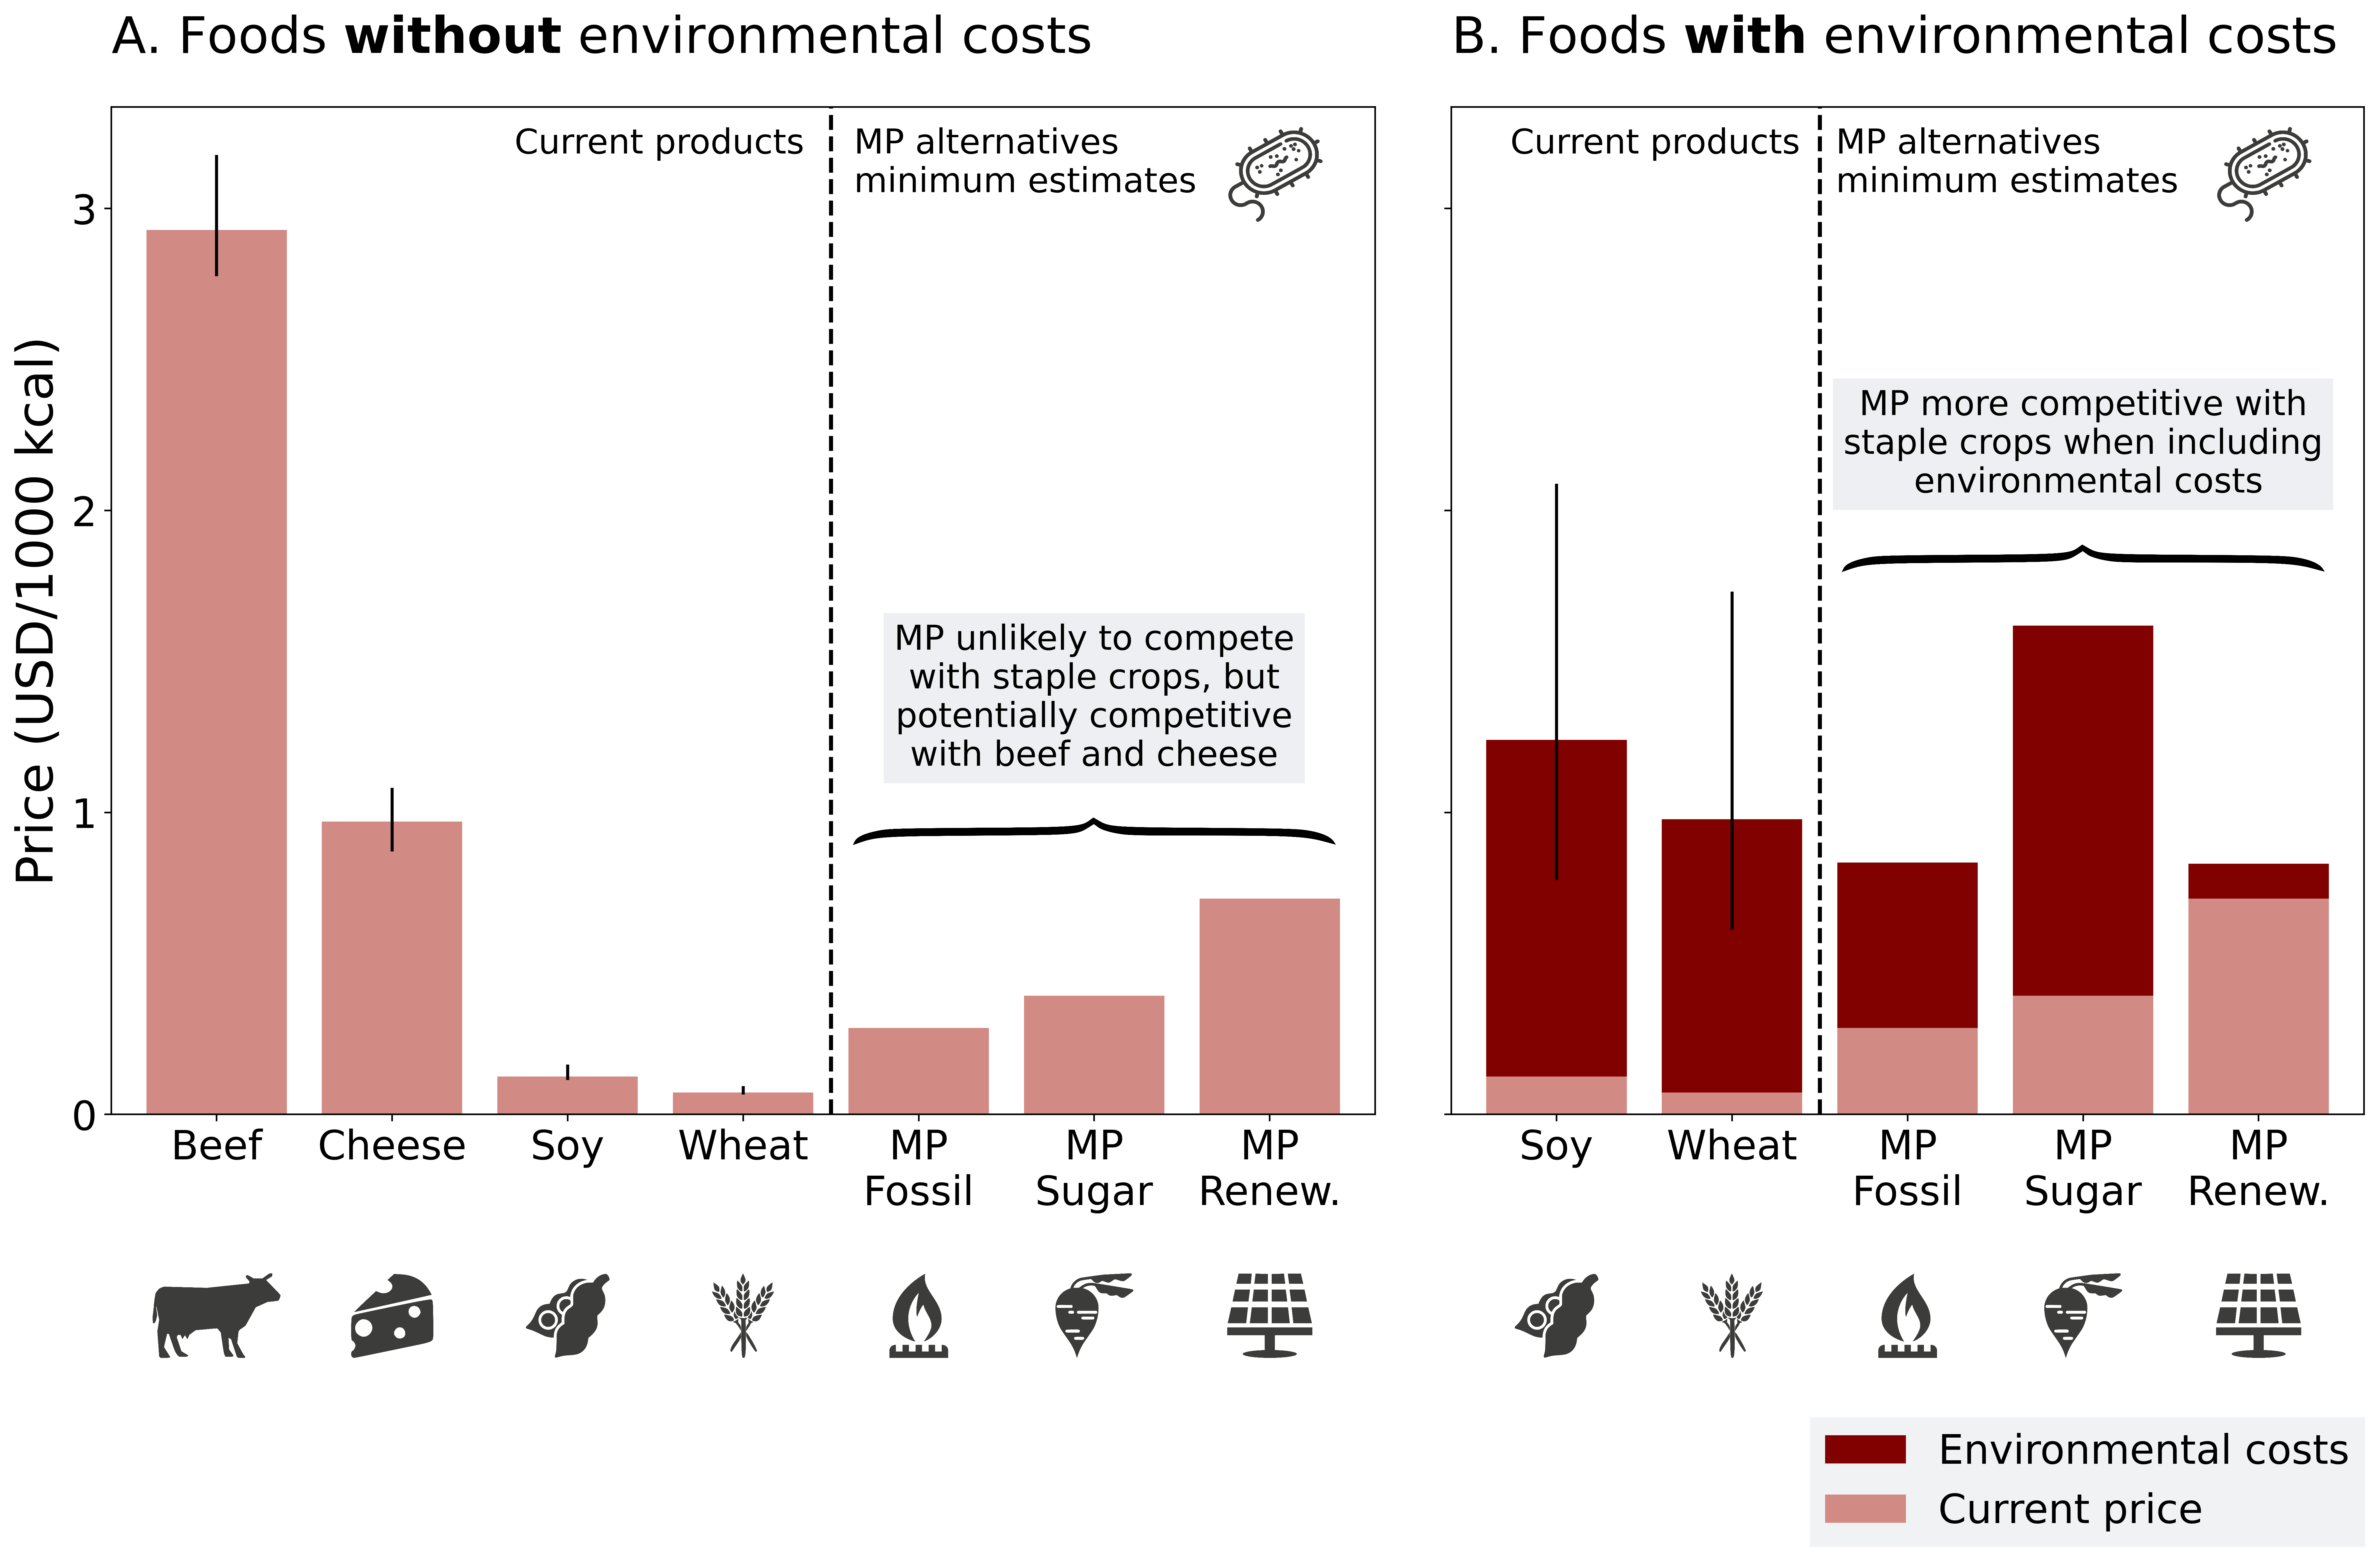

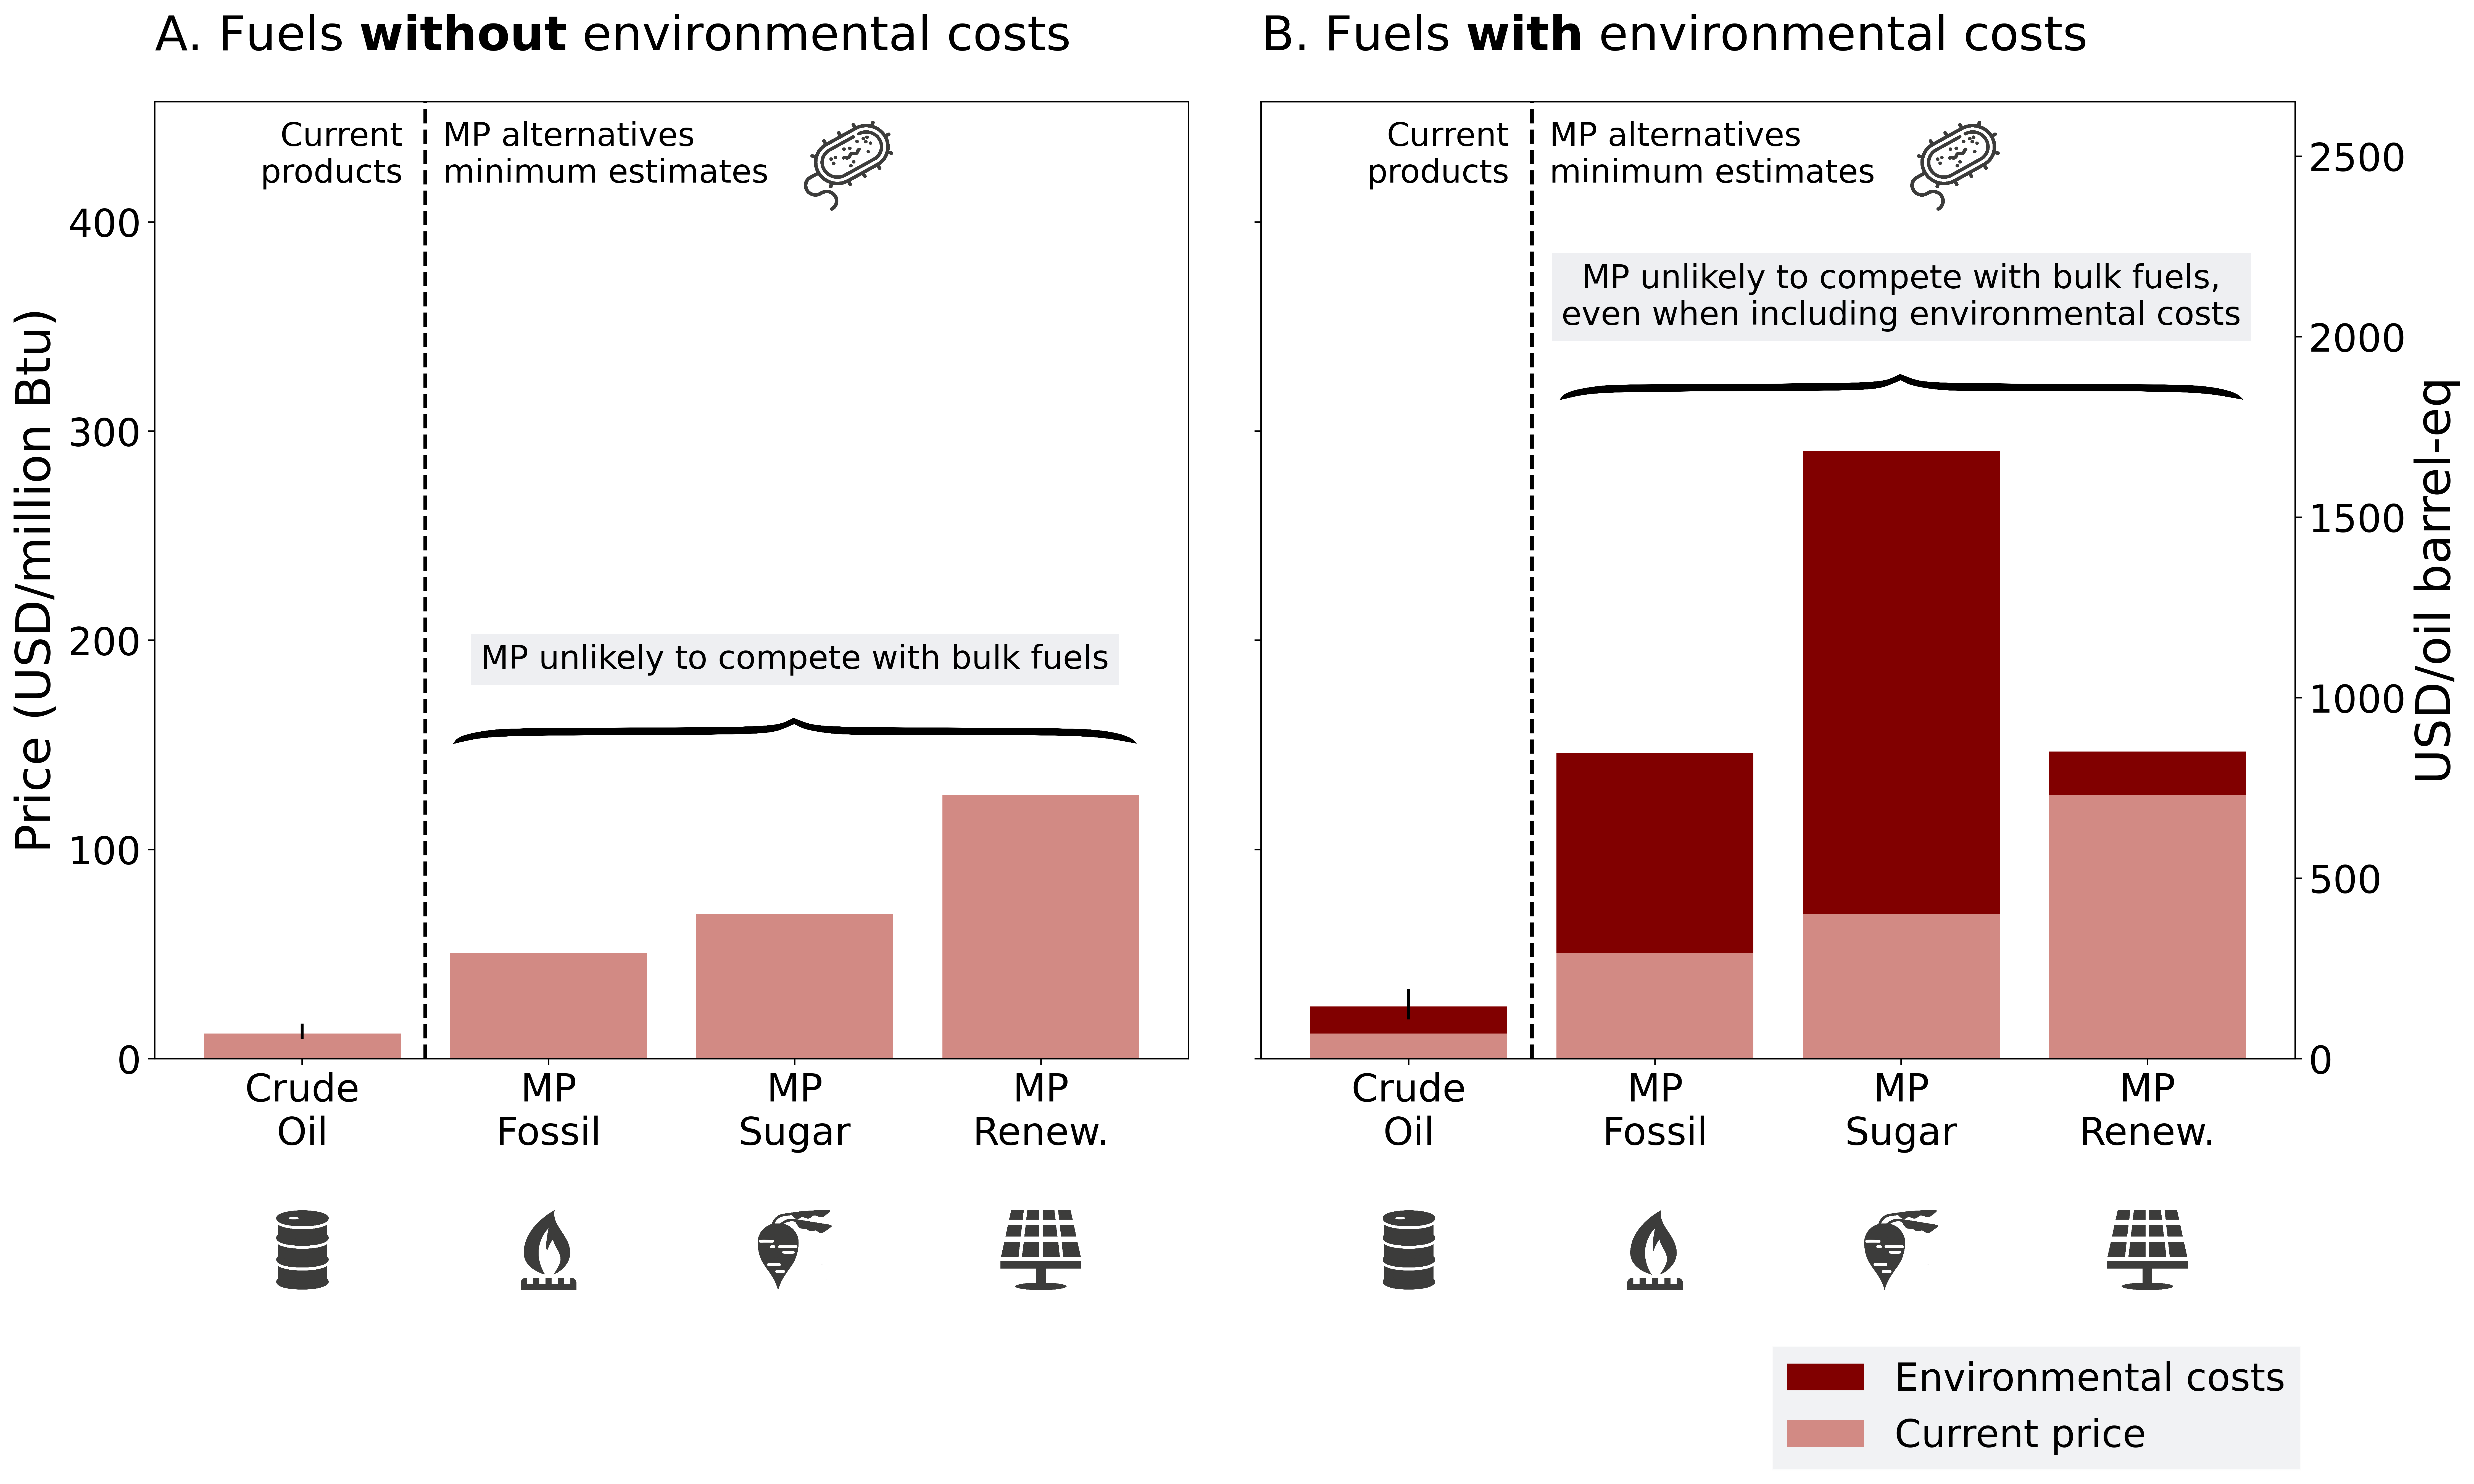

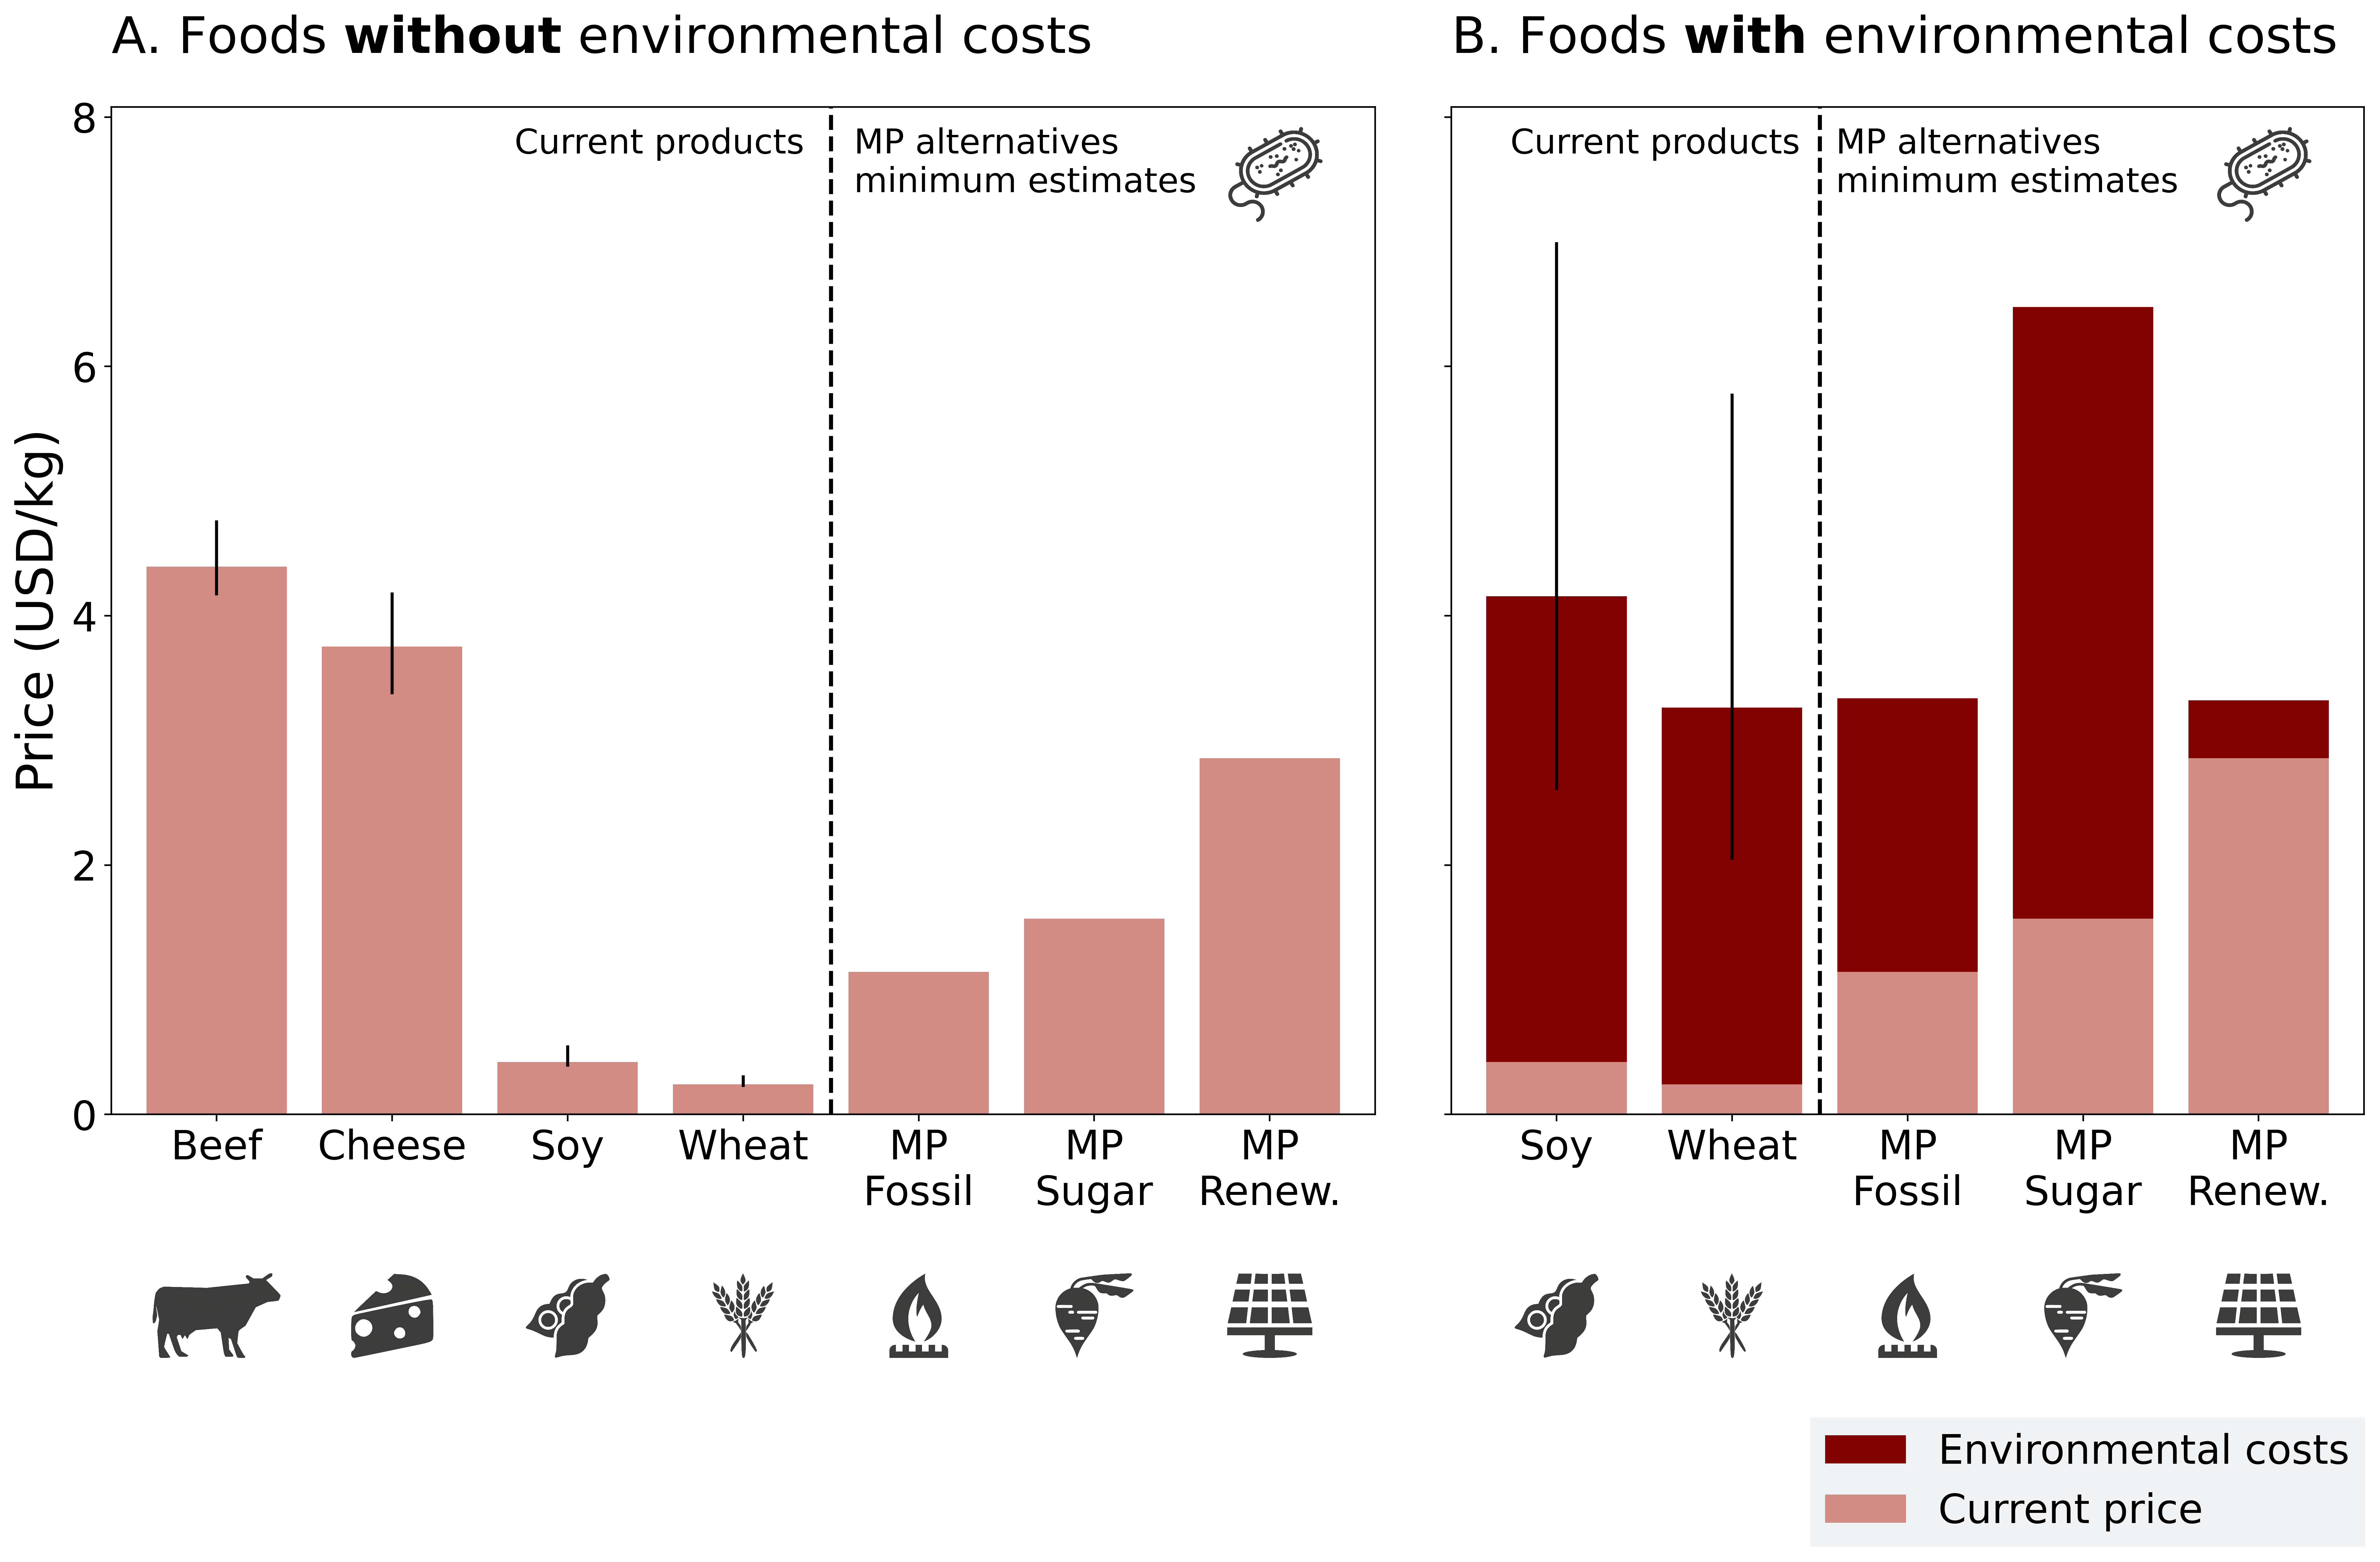

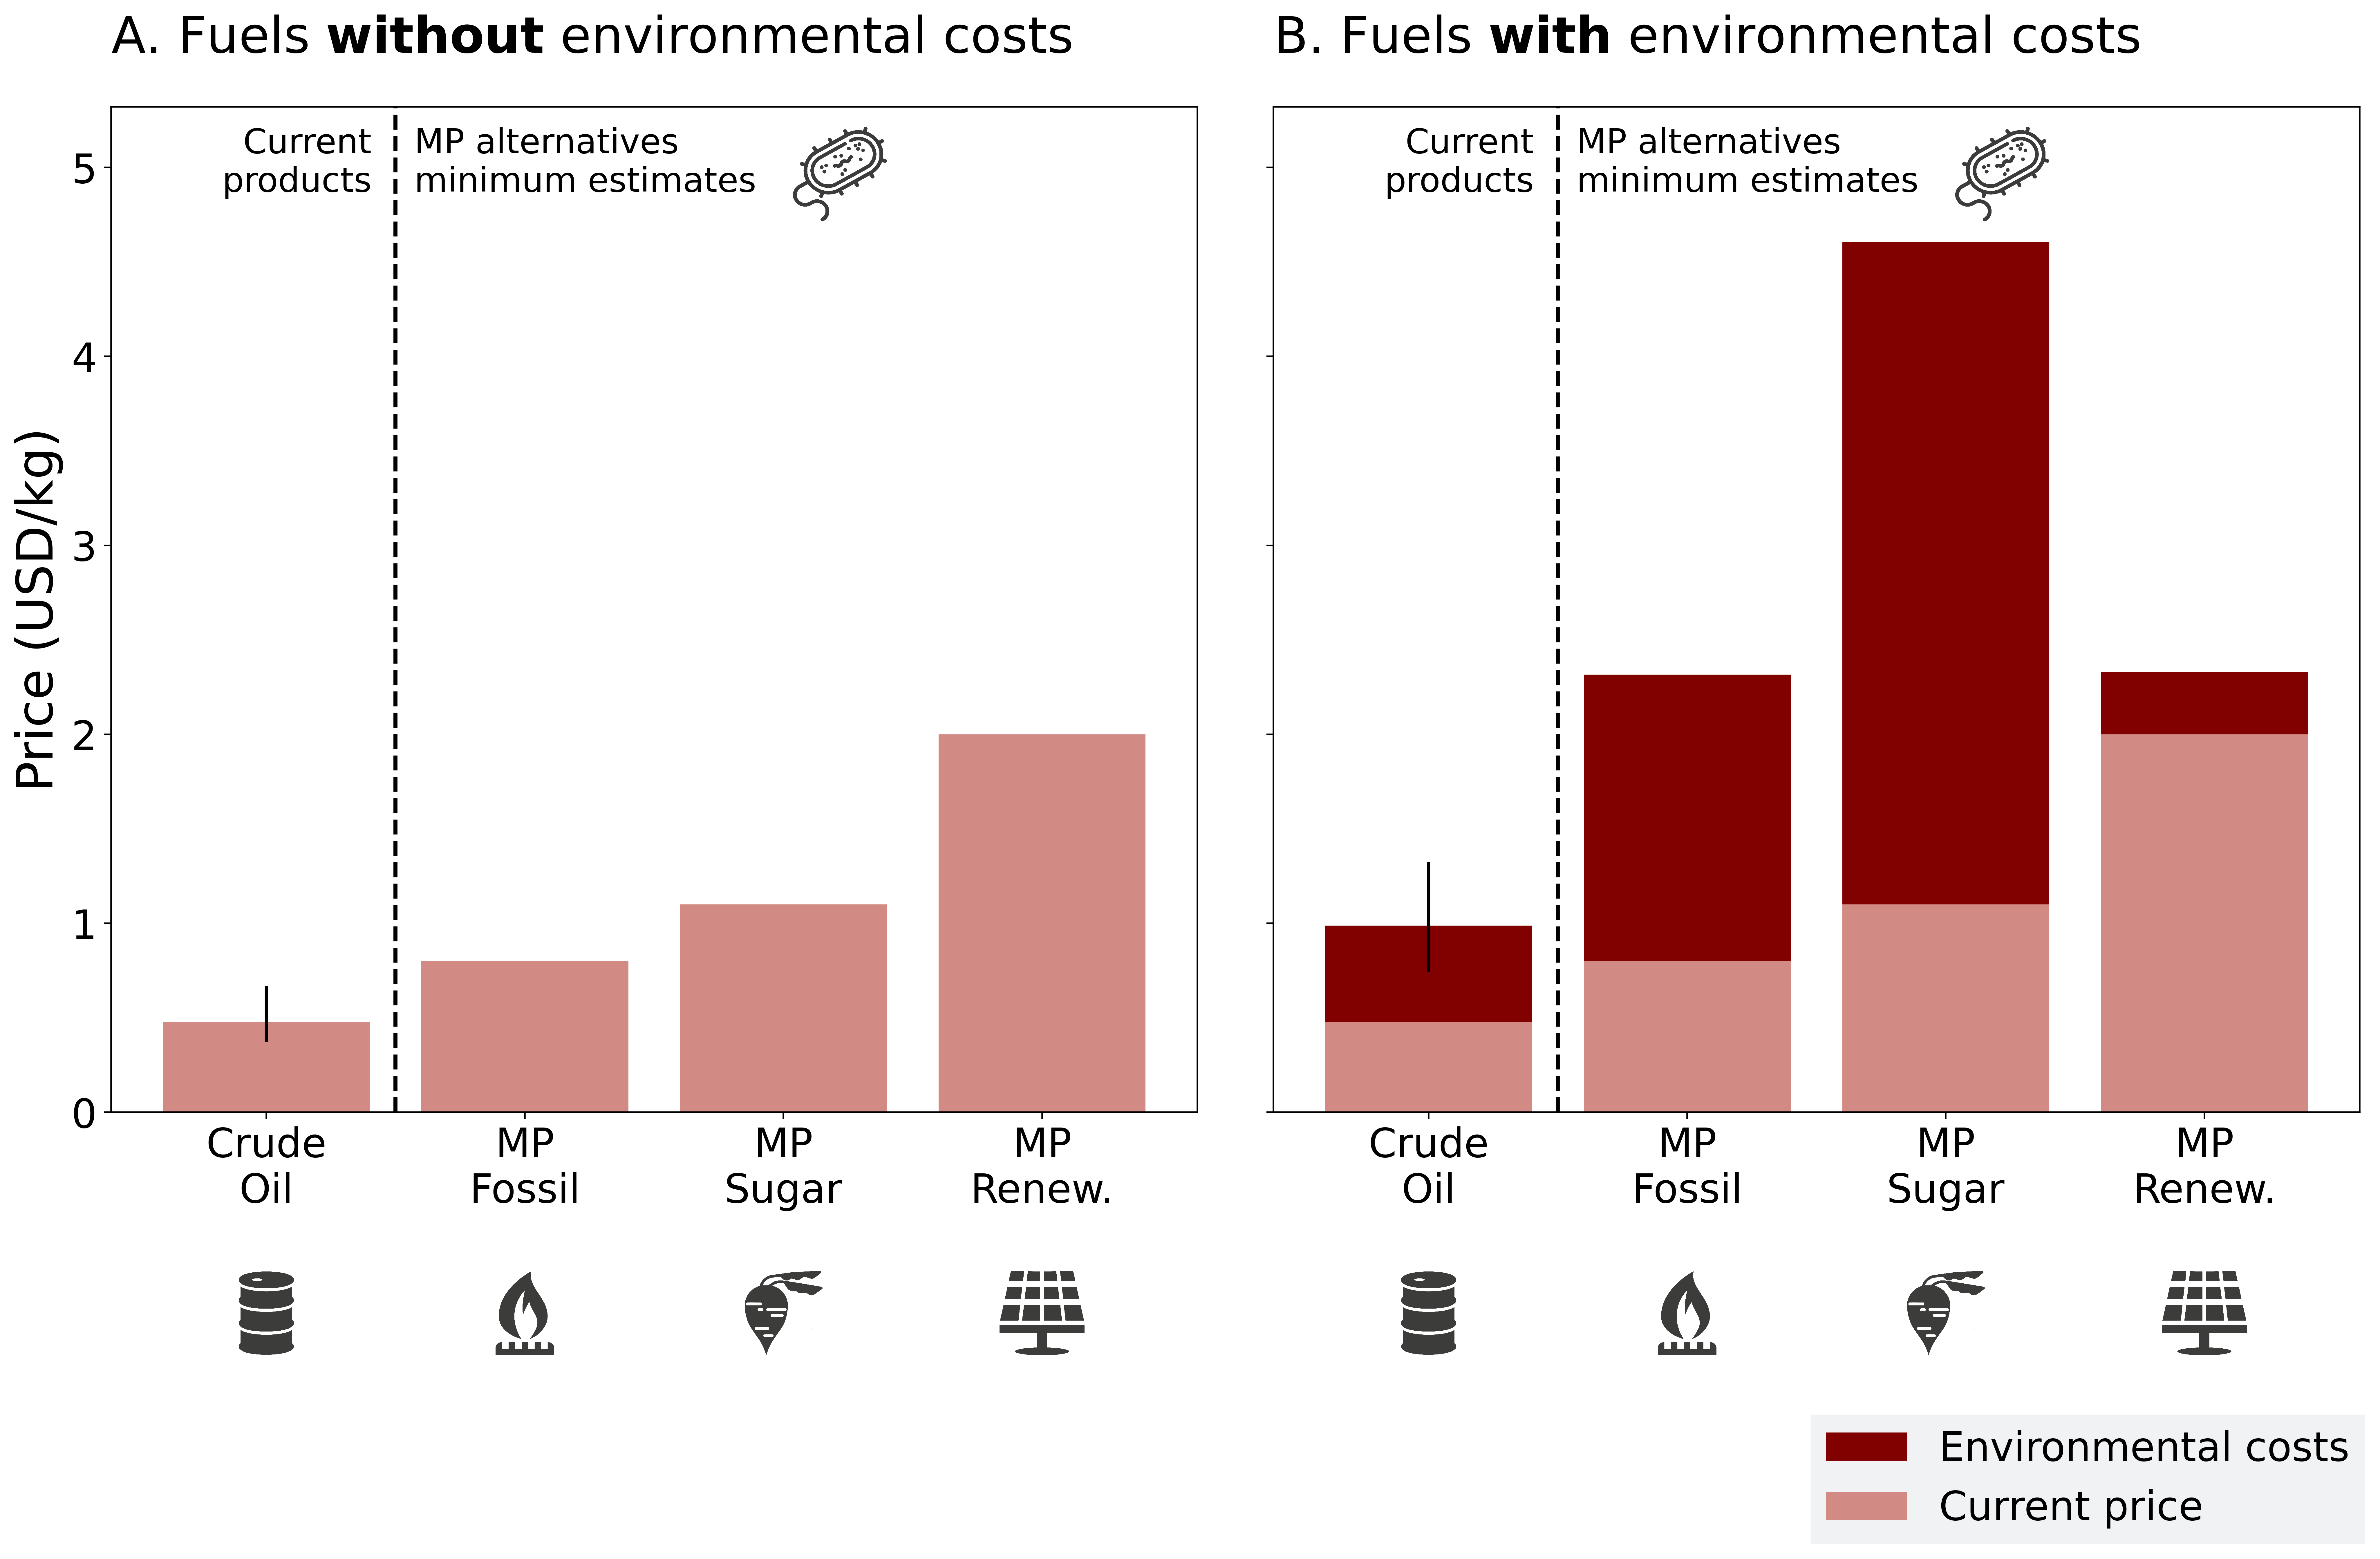

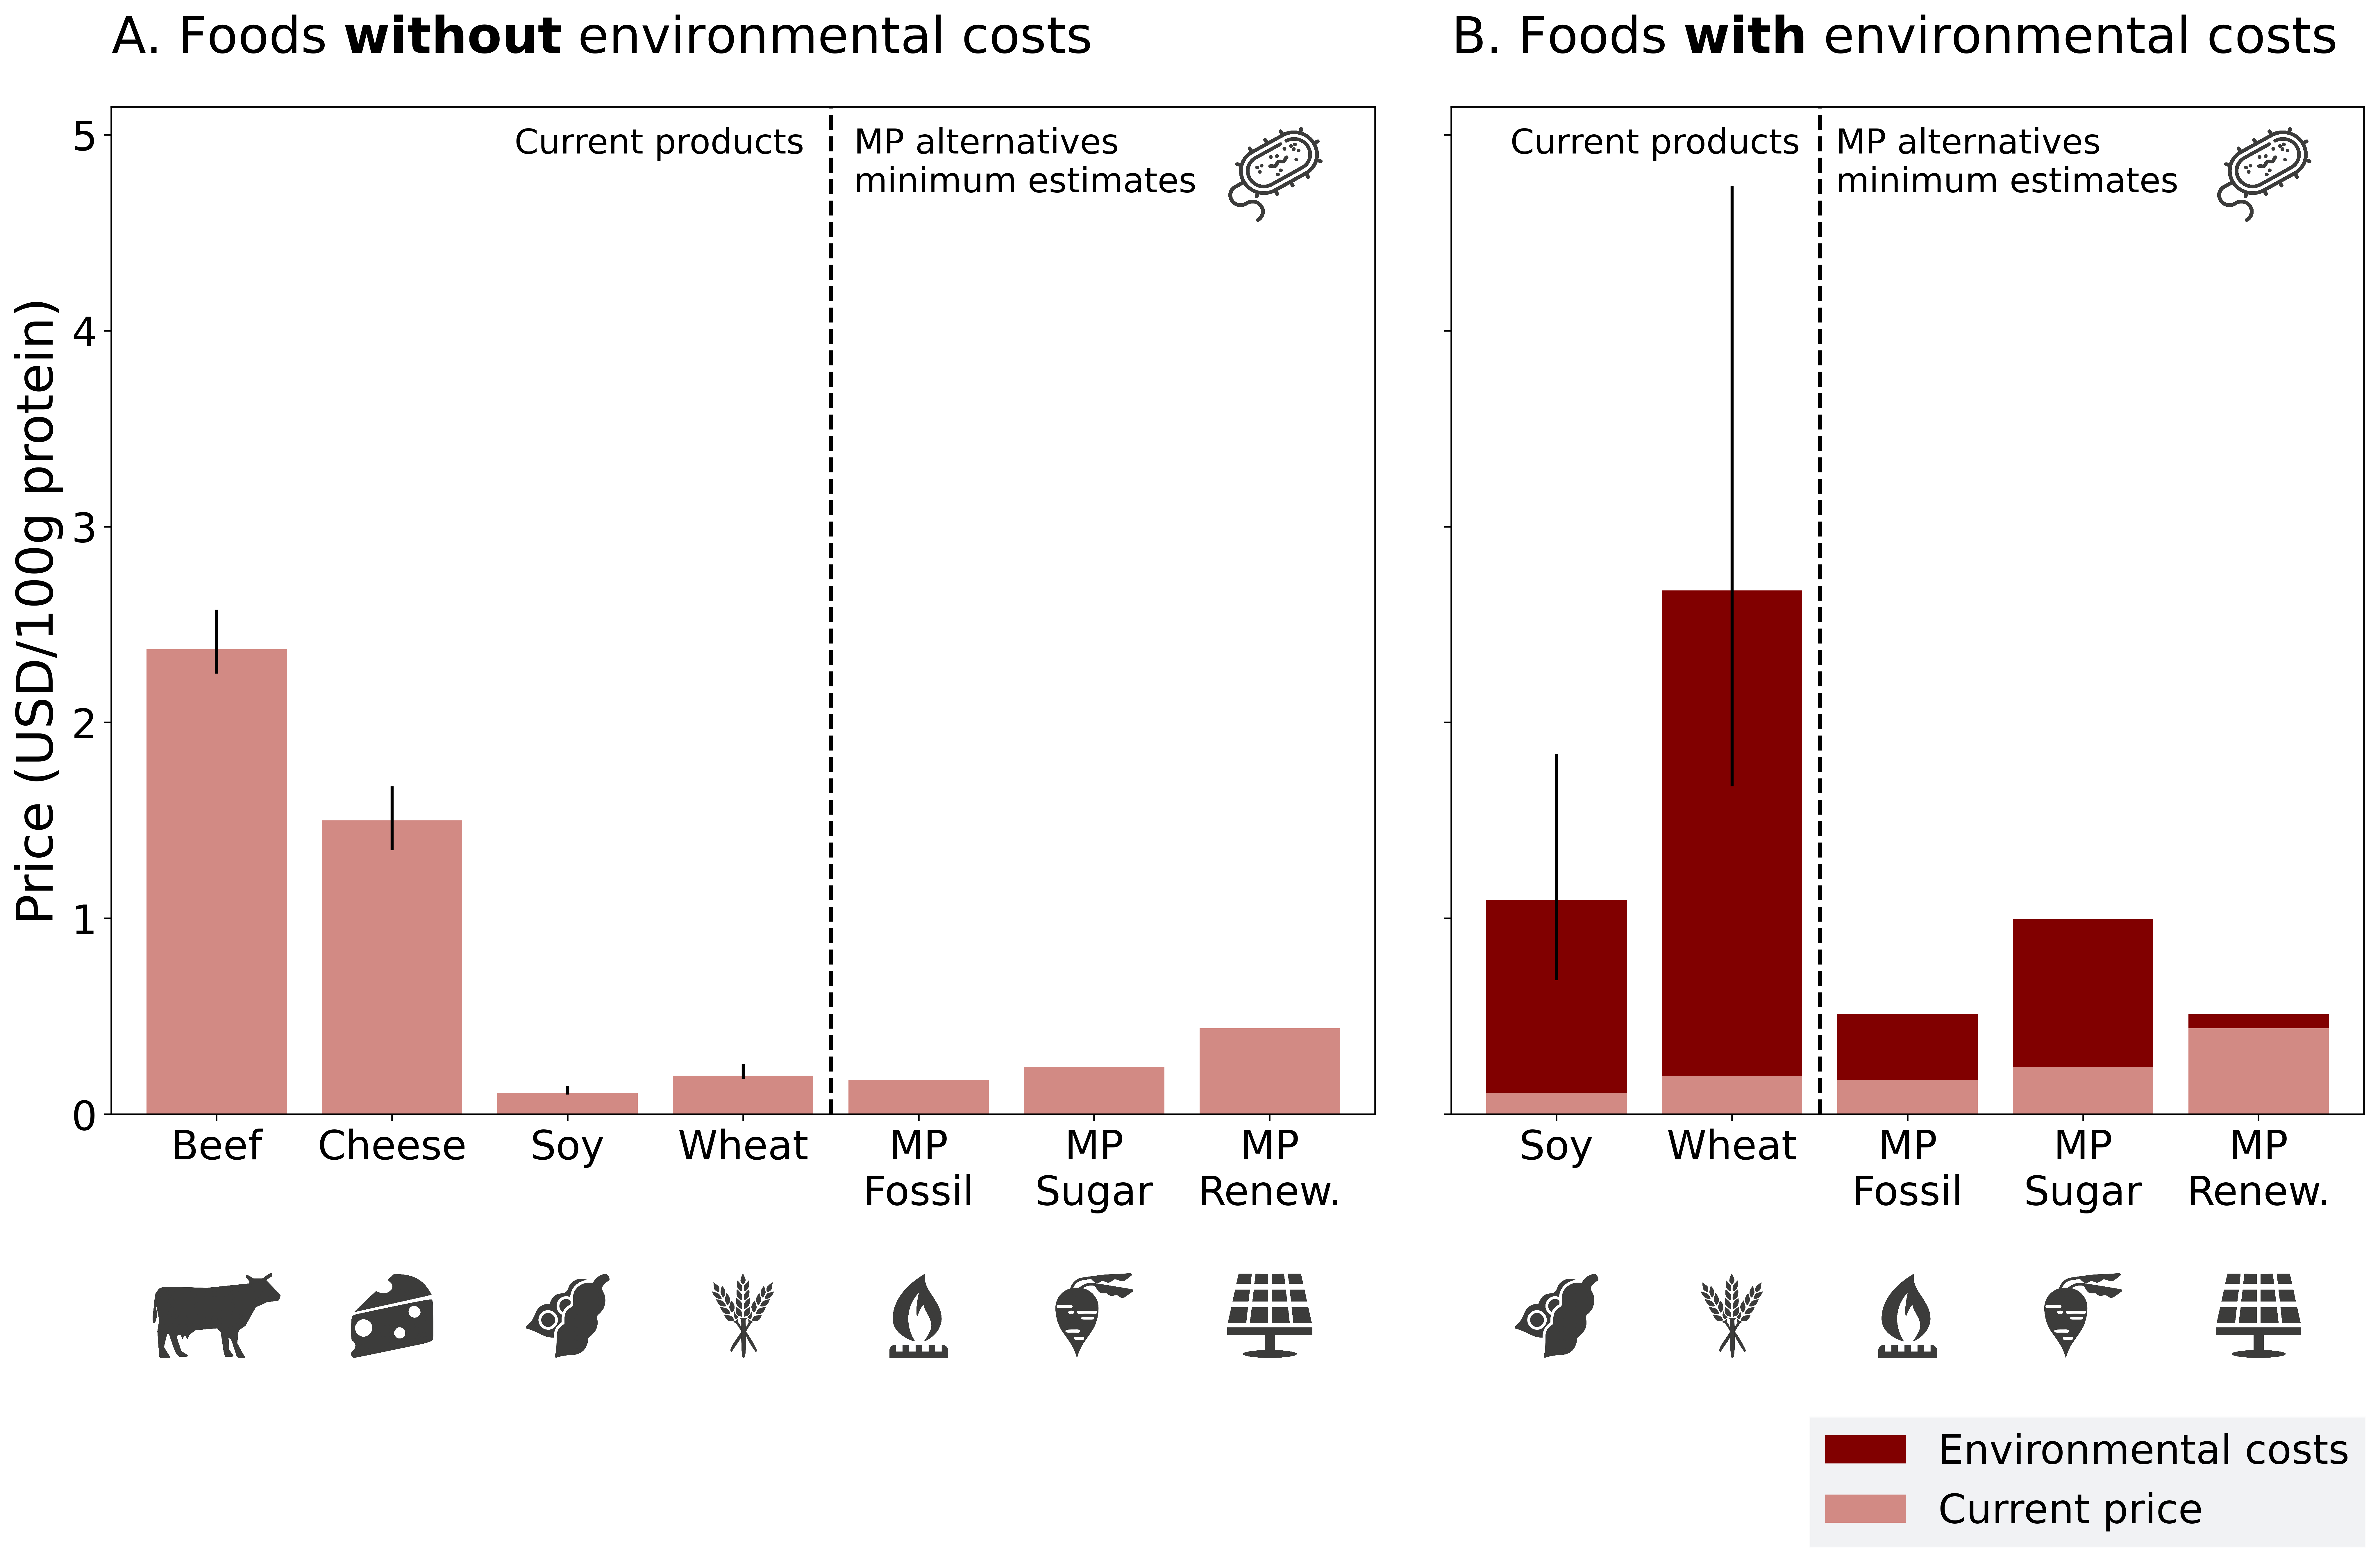

In [10]:
image_name_dict = {
    'Beef': 'beef',
    'Cheese': 'cheese',
    'Soybeans': 'soy', 
    'Wheat': 'wheat', 
    'Crude Oil': 'crude_oil',
    'MP Renewable Food': 'mp_solar',  
    'MP Sugar Food': 'mp_beet', 
    'MP Fossil Food': 'mp_ng',
    'MP Renewable Raw': 'mp_solar',  
    'MP Sugar Raw': 'mp_beet', 
    'MP Fossil Raw': 'mp_ng'
}

commodity_color = (210/255,138/255,132/255)
external_color = (129/255,0/255,0/255)

legend_names = [
    'Environmental costs', 
    'Current price', 
]

handles = [
    plt.Rectangle(
        (0,0),1,1, color=color, ec='w', lw=0
    ) for color in [external_color, commodity_color]
]

mcal_mbtu_conv = 252.2
#1 btu is 252.2 cal - https://www.iea.org/data-and-statistics/data-tools/unit-converter

for unit_cost in ['kcal', 'kg', 'protein']:    
    if unit_cost == 'kg':
        all_data = median_externalities_kg.copy()
        unit_label = 'kg'
        save_name = 'environmental_costs_kg'
    elif unit_cost == 'kcal':  
        all_data = median_externalities_kcal.copy()
        unit_label = '1000 kcal'
        save_name = 'environmental_costs_mcal'
    elif unit_cost == 'protein': 
        all_data = median_externalities_protein.copy()
        unit_label = '100g protein'
        save_name = 'environmental_costs_protein'



    all_data.sort_values('total_cost_w_env', ascending=True, inplace=True)
    df_fuels = all_data.loc[all_data.index.isin(fuels)].copy()
    df_foods = all_data.loc[all_data.index.isin(foods)].copy()
    df_mp_fuels = all_data.loc[all_data.index.isin(mp_fuel_products)].copy()
    df_mp_foods = all_data.loc[all_data.index.isin(mp_food_products)].copy()


    #plot microbial products as price increasing from left to right 
    #this contrasts lower price of current products with lowest price MP
    for dataframe in [df_fuels, df_foods]:
        dataframe.sort_values('commodity_price', ascending=False, inplace=True)
    df_mp_fuels.sort_values('commodity_price', ascending=True, inplace=True)
    df_mp_foods.sort_values('commodity_price', ascending=True, inplace=True)

    df_fuel_mp = pd.concat([df_fuels, df_mp_fuels])
    df_food_mp = pd.concat([df_foods, df_mp_foods])
    
    #set order of products based on kcal (figure in main text)
    #all figures have the same ordering
    if unit_cost == 'kcal':
        food_order = df_food_mp.index
        fuel_order = df_fuel_mp.index
    
    #no crude oil protein value so can plot figure
    #but delete protein plot later as protein content for fuels is meaningless
    if unit_cost == 'protein': 
        fuel_order = fuel_order[1::]
        
    fig_food, ax_food = plt.subplots(
        nrows=1, 
        ncols=2,
        figsize=(20, 9), 
        dpi=500, 
        sharey='row',  
        gridspec_kw={'width_ratios': [1, 5.2/7.2]}
    )
    

    fig_fuel, ax_fuel = plt.subplots(
        nrows=1, 
        ncols=2,
        figsize=(20, 9), 
        dpi=500, 
        sharey='row'
    )  
    
    #plot just commodity price in first subplot
    #then plot total price with environmental costs in the second subplot
    for data_to_plot, col, col_name, color, df_no_mp_len, axis, title, plot_order in (
        (
            df_food_mp, 
            0,  
            'commodity_price', 
            commodity_color, 
            len(df_foods),
            ax_food, 
            'A. Foods ' + r"$\bf{without}$" + ' environmental costs',
            food_order
        ),
        (
            df_food_mp[2::],
            1, 
            'total_cost_w_env', 
            external_color, 
            len(df_foods)-2,
            ax_food,
            'B. Foods ' + r"$\bf{with}$" + ' environmental costs',
            food_order[2::]
        ),
        (
            df_fuel_mp, 
            0,
            'commodity_price', 
            commodity_color, 
            len(df_fuels),
            ax_fuel,
            'A. Fuels ' + r"$\bf{without}$" + ' environmental costs',
            fuel_order
        ),
        (
            df_fuel_mp,  
            1, 
            'total_cost_w_env',  
            external_color, 
            len(df_fuels), 
            ax_fuel,
            'B. Fuels ' + r"$\bf{with}$" + ' environmental costs',
            fuel_order
        ),

    ):
        bar_width = 0.8
        #for fuels, show cost per british thermal energy for energy content
        #btu more common unit for fuels
        if unit_cost == 'kcal' and 'Fuels' in title:
            conversion = mcal_mbtu_conv
        else: 
            conversion = 1      

        x_pos_plot = 0
        for product in plot_order:   
            axis[col].bar(
                x=x_pos_plot, 
                height=data_to_plot.at[product, col_name]*conversion, 
                color=color,
                width=bar_width
            )

            if col == 1: 
                axis[col].bar(
                    x=x_pos_plot, 
                    height=data_to_plot.at[product, 'commodity_price']*conversion,
                    color=commodity_color,
                    width=bar_width
                )
            
            if col == 0:
                lower_col = 'lower_commodity'
                upper_col = 'upper_commodity'
            if col == 1:
                lower_col = 'low_cost_w_env'
                upper_col = 'up_cost_w_env'
                
            #add uncertainty
            #exclude MP as not sufficient data for uncertainty analysis  
            if not 'MP' in product:
                axis[col].vlines(
                    x_pos_plot, 
                    data_to_plot.at[product, lower_col]*conversion,
                    data_to_plot.at[product, upper_col]*conversion,
                    color='k',
                )
            x_pos_plot += 1

        x_labels = list(plot_order)
        x_labels = ['Soy' if x == 'Soybeans' else x for x in x_labels]
        x_labels = [label.replace('Raw', '') for label in x_labels]
        x_labels = [label.replace('Food', '') for label in x_labels]
        x_labels = [label.replace('Renewable', 'Renew.') for label in x_labels]
        #split up product names if too long
        x_labels = ["\n".join(wrap(r, 7, break_long_words=False)) for r in x_labels]
        x_idx = np.arange(len(data_to_plot))
        axis[col].set_xticks(x_idx, x_labels, fontsize=20)
        axis[col].set_xlim(-(bar_width/2+0.2), len(data_to_plot)-1+(bar_width/2+0.2))
        axis[col].tick_params(axis='both', which='major', labelsize=20)
        
        #separate MP estimates and current products with a line
        axis[col].axvline(
            df_no_mp_len-0.5, 
            color='k',
            ls='--',
            lw=2,
        )
        
        #spread the yticks nicely 
        axis[col].locator_params(axis='y', nbins=6)
        
        #add legend
        if col == 1:
            axis[1].legend(
                handles, 
                legend_names, 
                fontsize=20, 
                loc="lower right",
                labelspacing=0.5,
                facecolor=(238/255, 239/255, 242/255),
                edgecolor='w', 
                fancybox=False,
                bbox_to_anchor=(1.024, -0.45) #-0.022), 
            )
            
        #add y labels    
        if 'Fuels' in title and unit_cost == 'kcal': 
            unit_label = 'million Btu'  #more common unit for fuels than 1000 kcal
        
        if col == 0:
            axis[col].set_ylabel(
                f'Price (USD/{unit_label})', 
                fontsize=25,            
            )
            
        #increase y lim for fuels so that can add annotation to figure above bars
        if 'Fuels' in title and unit_cost != 'kcal' and col == 1:
            ax_fuel[1].set_ylim(
                0, ax_fuel[1].get_ylim()[1]+ax_fuel[1].get_ylim()[1]/10
            )
      
        #add title
        title = axis[col].set_title(
            title, 
            y=1.08, 
            x=0, 
            fontsize=25, 
            ha='left',
            va='top'
        )
    
    #add second yaxis for fuels to give oil barrel equivalent (common unit)   
    if unit_cost == 'kcal':
        ax_fuel[0].set_ylim(
            0, ax_fuel[0].get_ylim()[1]+ax_fuel[0].get_ylim()[1]/2
        )
        axis_boe = ax_fuel[1].twinx()
        j_per_barrel = 6.119e9  #BP Statistical Review of World Energy conversion factors
        j_per_mcal = 4.1868e6  #BP Statistical Review of World Energy conversion factors
        mcal_barrel = j_per_barrel/j_per_mcal
        btu_barrel = mcal_barrel/mcal_mbtu_conv

        axis_boe.set_ylim(0, axis[col].get_ylim()[1]*btu_barrel)
        axis_boe.set_ylabel(
            'USD/oil barrel-eq', 
            color='k', 
            fontsize=25
        )
        axis_boe.tick_params(
            axis='both', 
            which='major', 
            labelsize=20,
        )
    
    #add padding so that bars don't overlap with annotations added below 
    #padding determined manually
    if unit_cost == 'kg':
        ax_food[0].set_ylim(
            0, ax_food[0].get_ylim()[1]+ax_food[0].get_ylim()[1]/10
        )
    if unit_cost == 'protein':
        ax_food[0].set_ylim(
            0, ax_food[0].get_ylim()[1]+ax_food[0].get_ylim()[1]/30
        )
          
    #annotate left and right side of panels to indicate different meanings
    #do this after all things plotted as ylims change due to shared axes
    #which alters text positions
    for axis, col, df_no_mp_len in (
        (ax_food, 0, len(df_foods)),
        (ax_food, 1, len(df_foods)-2),
        (ax_fuel, 0, len(df_fuels)),
        (ax_fuel, 1,  len(df_fuels))
    ):
        vline_xloc = df_no_mp_len-0.5
        x_offset = axis[col].get_xlim()[1]/50
        yloc = axis[col].get_ylim()[1]
        y_offset = axis[col].get_ylim()[1]/50

        text = axis[col].annotate(
            text='MP alternatives\nminimum estimates', 
            xy=(
                vline_xloc+x_offset, 
                yloc-y_offset
            ),
            xytext=(
                vline_xloc+x_offset, 
                yloc-y_offset
            ),
            annotation_clip=False,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=17, 
            zorder=10,            
        )

        if df_no_mp_len < 2:
            text = 'Current\nproducts'
        else: 
            text = 'Current products'

        #whether ha align left and right slightly shifts things
        #therefore include 0.02 to adjust
        text = axis[col].annotate(
            text=text, 
            xy=(
                vline_xloc-x_offset-0.02, 
                yloc-y_offset
            ),
            xytext=(
                vline_xloc-x_offset-0.02, 
                yloc-y_offset
            ),
            annotation_clip=False,
            verticalalignment='top',
            horizontalalignment='right',
            fontsize=17, 
            zorder=10,            
        )
        
       
    #add product icons
    #do this after ylims are fixed so positions of icon don't change
    for df_plot, col, axis, df_no_mp_len, plot_order in (
        (df_food_mp, 0, ax_food, len(df_foods), food_order), 
        (df_food_mp[2::], 1, ax_food, len(df_foods)-2, food_order[2::]),
        (df_fuel_mp, 0, ax_fuel, len(df_fuels), fuel_order),
        (df_fuel_mp, 1, ax_fuel, len(df_fuels), fuel_order)
    ):
        y_pos_icon = -(axis[col].get_ylim()[1]-axis[col].get_ylim()[0])/5
        x_pos_icon = 0
        for product in plot_order:
            product_img = plt.imread(f"{image_name_dict[product]}.png")
            scaled_image = OffsetImage(product_img, zoom=.038)
            product_icon_plot = AnnotationBbox(
                scaled_image, (x_pos_icon, y_pos_icon), 
                xycoords='data', 
                box_alignment=(0.5,0.5), 
                frameon=False, 
                annotation_clip=False
            )
            axis[col].add_artist(product_icon_plot)
            x_pos_icon += 1
        
        #add mp icon
        if 'Food' in axis[col].get_title(): 
            xloc_mp_icon = df_no_mp_len+2.3   
        else: 
            xloc_mp_icon = df_no_mp_len+1.4
        yloc_mp_icon = axis[col].get_ylim()[1] - axis[col].get_ylim()[1]/50

        mp_img = plt.imread(f"mp.png") 
        mp_image_scaled = OffsetImage(mp_img, zoom=.03)
        mp_icon_plot = AnnotationBbox(
            mp_image_scaled, (xloc_mp_icon, yloc_mp_icon), 
            xycoords='data', 
            box_alignment=(1,1), 
            frameon=False, 
            annotation_clip=False
        )
        axis[col].add_artist(mp_icon_plot)
     
    
    #add annotations just for main plot, not SI figs 
    if unit_cost == 'kcal':
        for df_plot, col, axis, df_no_mp_len, col_lim, brace_scale, text in (
            (
                df_mp_foods,
                0, 
                ax_food, 
                len(df_foods), 
                df_mp_foods['commodity_price'].max(),
                1.12,  #manually determined to make brace fit as best as possible
                'MP unlikely to compete\nwith staple crops, but\npotentially competitive\nwith beef and cheese'
            ), 
            (
                df_mp_foods, 
                1, 
                ax_food, 
                len(df_foods)-2, 
                df_mp_foods['total_cost_w_env'].max(),
                1.12,
                'MP more competitive with\nstaple crops when including\n environmental costs'
            ),
            (
                df_mp_fuels, 
                0, 
                ax_fuel, 
                len(df_fuels), 
                df_mp_fuels['commodity_price'].max()*mcal_mbtu_conv,
                1.67,
                'MP unlikely to compete with bulk fuels'
            ),
            (
                df_mp_fuels, 
                1, 
                ax_fuel, 
                len(df_fuels), 
                df_mp_fuels['total_cost_w_env'].max()*mcal_mbtu_conv,
                1.67,
                'MP unlikely to compete with bulk fuels,\neven when including environmental costs'
            )
        ):
            #add scale parameter for brace
            brace_icon = Image.open('curly_brace.png')
            width, height = brace_icon.size
            new_brace_size = brace_icon.resize((int(width*brace_scale), int(height)))
            brace_icon_scaled = OffsetImage(new_brace_size, zoom=.038)
            
            #place brace over mp bars
            x_pos_annotation = df_no_mp_len + len(df_plot)/2 - 0.5
            y_pos_annotation = col_lim + axis[col].get_ylim()[1]/15
            brace_icon_plot = AnnotationBbox(
                brace_icon_scaled, (x_pos_annotation, y_pos_annotation), 
                xycoords='data', 
                box_alignment=(0.5,0.5), 
                frameon=False, 
                annotation_clip=False
            )
            axis[col].add_artist(brace_icon_plot)

            #place annotation over the brace
            props = dict(
                boxstyle='square', 
                facecolor=(238/255, 239/255, 242/255), 
                alpha=1,
                lw=0
            )
            axis[col].text(
                x_pos_annotation, 
                col_lim + axis[col].get_ylim()[1]/8, 
                text, 
                fontsize=17,
                va='bottom',
                ha='center',
                bbox=props
            )


    #protein is irrelevant for fuels, so don't plot
    if unit_cost == 'protein':
        plt.close(fig_fuel)
        
        
    fig_food.subplots_adjust(wspace=0.07)
    fig_fuel.subplots_adjust(wspace=0.07)

    plt.show()

    #fig_food.savefig(f'{save_name}_food.svg', bbox_inches='tight')
    #fig_fuel.savefig(f'{save_name}_fuel.svg', bbox_inches='tight')

In [11]:
commodity_color = (210/255,138/255,132/255)
external_color = (129/255,0/255,0/255)

legend_names = [
    'Environmental costs', 
    'Current price', 
]

handles = [
    plt.Rectangle(
        (0,0),1,1, color=color, ec='w', lw=0
    ) for color in [external_color, commodity_color]
]


for unit_cost in ['kcal', 'kg', 'protein']:    
    if unit_cost == 'kg':
        all_data = median_externalities_kg.copy()
        unit_label = 'kg'
        save_name = 'environmental_costs_kg'
    elif unit_cost == 'kcal':  
        all_data = median_externalities_kcal.copy()
        unit_label = '1000 kcal'
        save_name = 'environmental_costs_mcal'
    elif unit_cost == 'protein': 
        all_data = median_externalities_protein.copy()
        unit_label = '100g protein'
        save_name = 'environmental_costs_protein'

    all_data.sort_values('total_cost_w_env', ascending=True, inplace=True)
    df_foods = all_data.loc[all_data.index.isin(foods)].copy()
    df_mp_foods = all_data.loc[all_data.index.isin(mp_food_products)].copy()


    df_foods.sort_values('commodity_price', ascending=False, inplace=True)
    #plot microbial products as price increasing from left to right 
    #this contrasts lower price of current products with lowest price MP
    df_mp_foods.sort_values('commodity_price', ascending=True, inplace=True)
    
    df_food_mp = pd.concat([df_foods, df_mp_foods])
    
    if unit_cost == 'kcal':
        food_order = df_food_mp.index
    
    fig, ax = plt.subplots(
        nrows=1, 
        ncols=2,
        figsize=(22, 24), 
        dpi=500, 
        sharey='row',  
        gridspec_kw={'width_ratios': [1, 1]}
    )    

    for data_to_plot, col, col_name, color, df_no_mp_len, axis, title in (
        (
            df_food_mp, 
            0,  
            'commodity_price', 
            commodity_color, 
            len(df_foods),
            ax, 
            'A. Foods ' + r"$\bf{without}$" + ' environmental costs'
        ),
        (
            df_food_mp,
            1, 
            'total_cost_w_env', 
            external_color, 
            len(df_foods),
            ax,
            'B. Foods ' + r"$\bf{with}$" + ' environmental costs'
        )
    ):

        #add uncertainty
        #exclude MP as not sufficient data for uncertainty analysis 
        x_pos_plot = 0
        for product in food_order:   
            axis[col].bar(
                x=x_pos_plot, 
                height=data_to_plot.at[product, col_name]*conversion, 
                color=color,
                width=bar_width
            )

            if col == 1: 
                axis[col].bar(
                    x=x_pos_plot, 
                    height=data_to_plot.at[product, 'commodity_price']*conversion,
                    color=commodity_color,
                    width=bar_width
                )
            
            if col == 0:
                lower_col = 'lower_commodity'
                upper_col = 'upper_commodity'
            if col == 1:
                lower_col = 'low_cost_w_env'
                upper_col = 'up_cost_w_env'
                
            #add uncertainty
            #exclude MP as not sufficient data for uncertainty analysis  
            if not 'MP' in product:
                axis[col].vlines(
                    x_pos_plot, 
                    data_to_plot.at[product, lower_col]*conversion,
                    data_to_plot.at[product, upper_col]*conversion,
                    color='k',
                )
            x_pos_plot += 1

        x_labels = list(food_order)
        x_labels = ['Soy' if x == 'Soybeans' else x for x in x_labels]
        x_labels = [label.replace('Raw', '') for label in x_labels]
        x_labels = [label.replace('Food', '') for label in x_labels]
        x_labels = [label.replace('Renewable', 'Renew.') for label in x_labels]
        #split up product names if too long
        x_labels = ["\n".join(wrap(r, 7, break_long_words=False)) for r in x_labels]
        x_idx = np.arange(len(data_to_plot))
        axis[col].set_xticks(x_idx, x_labels, fontsize=20)
        axis[col].set_xlim(-(bar_width/2+0.2), len(data_to_plot)-1+(bar_width/2+0.2))
        axis[col].tick_params(axis='both', which='major', labelsize=20)
        
        axis[col].yaxis.set_tick_params(labelbottom=True)

        #add vertical dashed line to plot
        axis[col].axvline(
            df_no_mp_len-0.5, 
            color='k',
            ls='--',
            lw=2,
        )
        #make sure the yticks are nicely spread
        
        #add legend
        if col == 1:
            axis[1].legend(
                handles, 
                legend_names, 
                fontsize=20, 
                loc="lower right",
                labelspacing=0.5,
                facecolor=(238/255, 239/255, 242/255),
                edgecolor='w', 
                fancybox=False,
                bbox_to_anchor=(1.024, -0.13), 
            )
            

        if col == 0:
            axis[col].set_ylabel(
                f'Price (USD/{unit_label})', 
                fontsize=25,            
            )
            
        #add title
        title = axis[col].set_title(
            title, 
            y=1.03, 
            x=0, 
            fontsize=25, 
            ha='left',
            va='top'
        )
    
    #annotate left and right side of panels to indicate different meanings
    #do this after all things plotted as ylims change due to shared axes
    #which alters text positions
    for axis, col, df_no_mp_len in (
        (ax, 0, len(df_foods)),
        (ax, 1, len(df_foods)),
    ):
        vline_xloc = df_no_mp_len-0.5
        x_offset = axis[col].get_xlim()[1]/50
        yloc = axis[col].get_ylim()[1]
        y_offset = axis[col].get_ylim()[1]/100

        text = axis[col].annotate(
            text='MP alternatives\nminimum estimates', 
            xy=(
                vline_xloc+x_offset, 
                yloc-y_offset
            ),
            xytext=(
                vline_xloc+x_offset, 
                yloc-y_offset
            ),
            annotation_clip=False,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=17, 
            zorder=10,            
        )

        #whether ha align left and right slightly shifts things
        #therefore include 0.02 to adjust
        text = axis[col].annotate(
            text= 'Current products', 
            xy=(
                vline_xloc-x_offset-0.02, 
                yloc-y_offset
            ),
            xytext=(
                vline_xloc-x_offset-0.02, 
                yloc-y_offset
            ),
            annotation_clip=False,
            verticalalignment='top',
            horizontalalignment='right',
            fontsize=17, 
            zorder=10,            
        )

    fig.subplots_adjust(wspace=0.15)

    plt.show()

    #fig.savefig(f'{save_name}_food_long.svg', bbox_inches='tight')


### Price breakdown: mean contribution of each environmental impact towards the total environmental cost for each product

In [12]:
def round_to_n(x,n ):
    if x == 0: 
        return 0
    else:
        num = round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))
    if num >= 10 and n < 3:
        num = int(num)
    return num

In [13]:
#calculate percent of total env cost each impact is for each run
#take mean contribution of each env impact to total env costs (sums to 1)
#environmental cost breakdown is the same if do kg, kcal or protein
percents_env_costs = {}
for product in sampled_externalities_df.columns.levels[0]:
    env_costs_df = sampled_externalities_df[product][
        [
            'ghg_kg_co2eq', 
            'land_m2', 
            'water_cons_l', 
            'eutr_kg_phoseq', 
            'acid_kg_so2eq'
        ]
    ]
    percents = 100* (
        env_costs_df
        .div(env_costs_df.sum(axis=1), axis=0)
    )
    percents_env_costs[(product, 'mean')] = percents.mean(axis=0)
    percents_env_costs[(product, 'median')] = percents.median(axis=0)
    
percents_env_costs_df = pd.DataFrame(percents_env_costs)

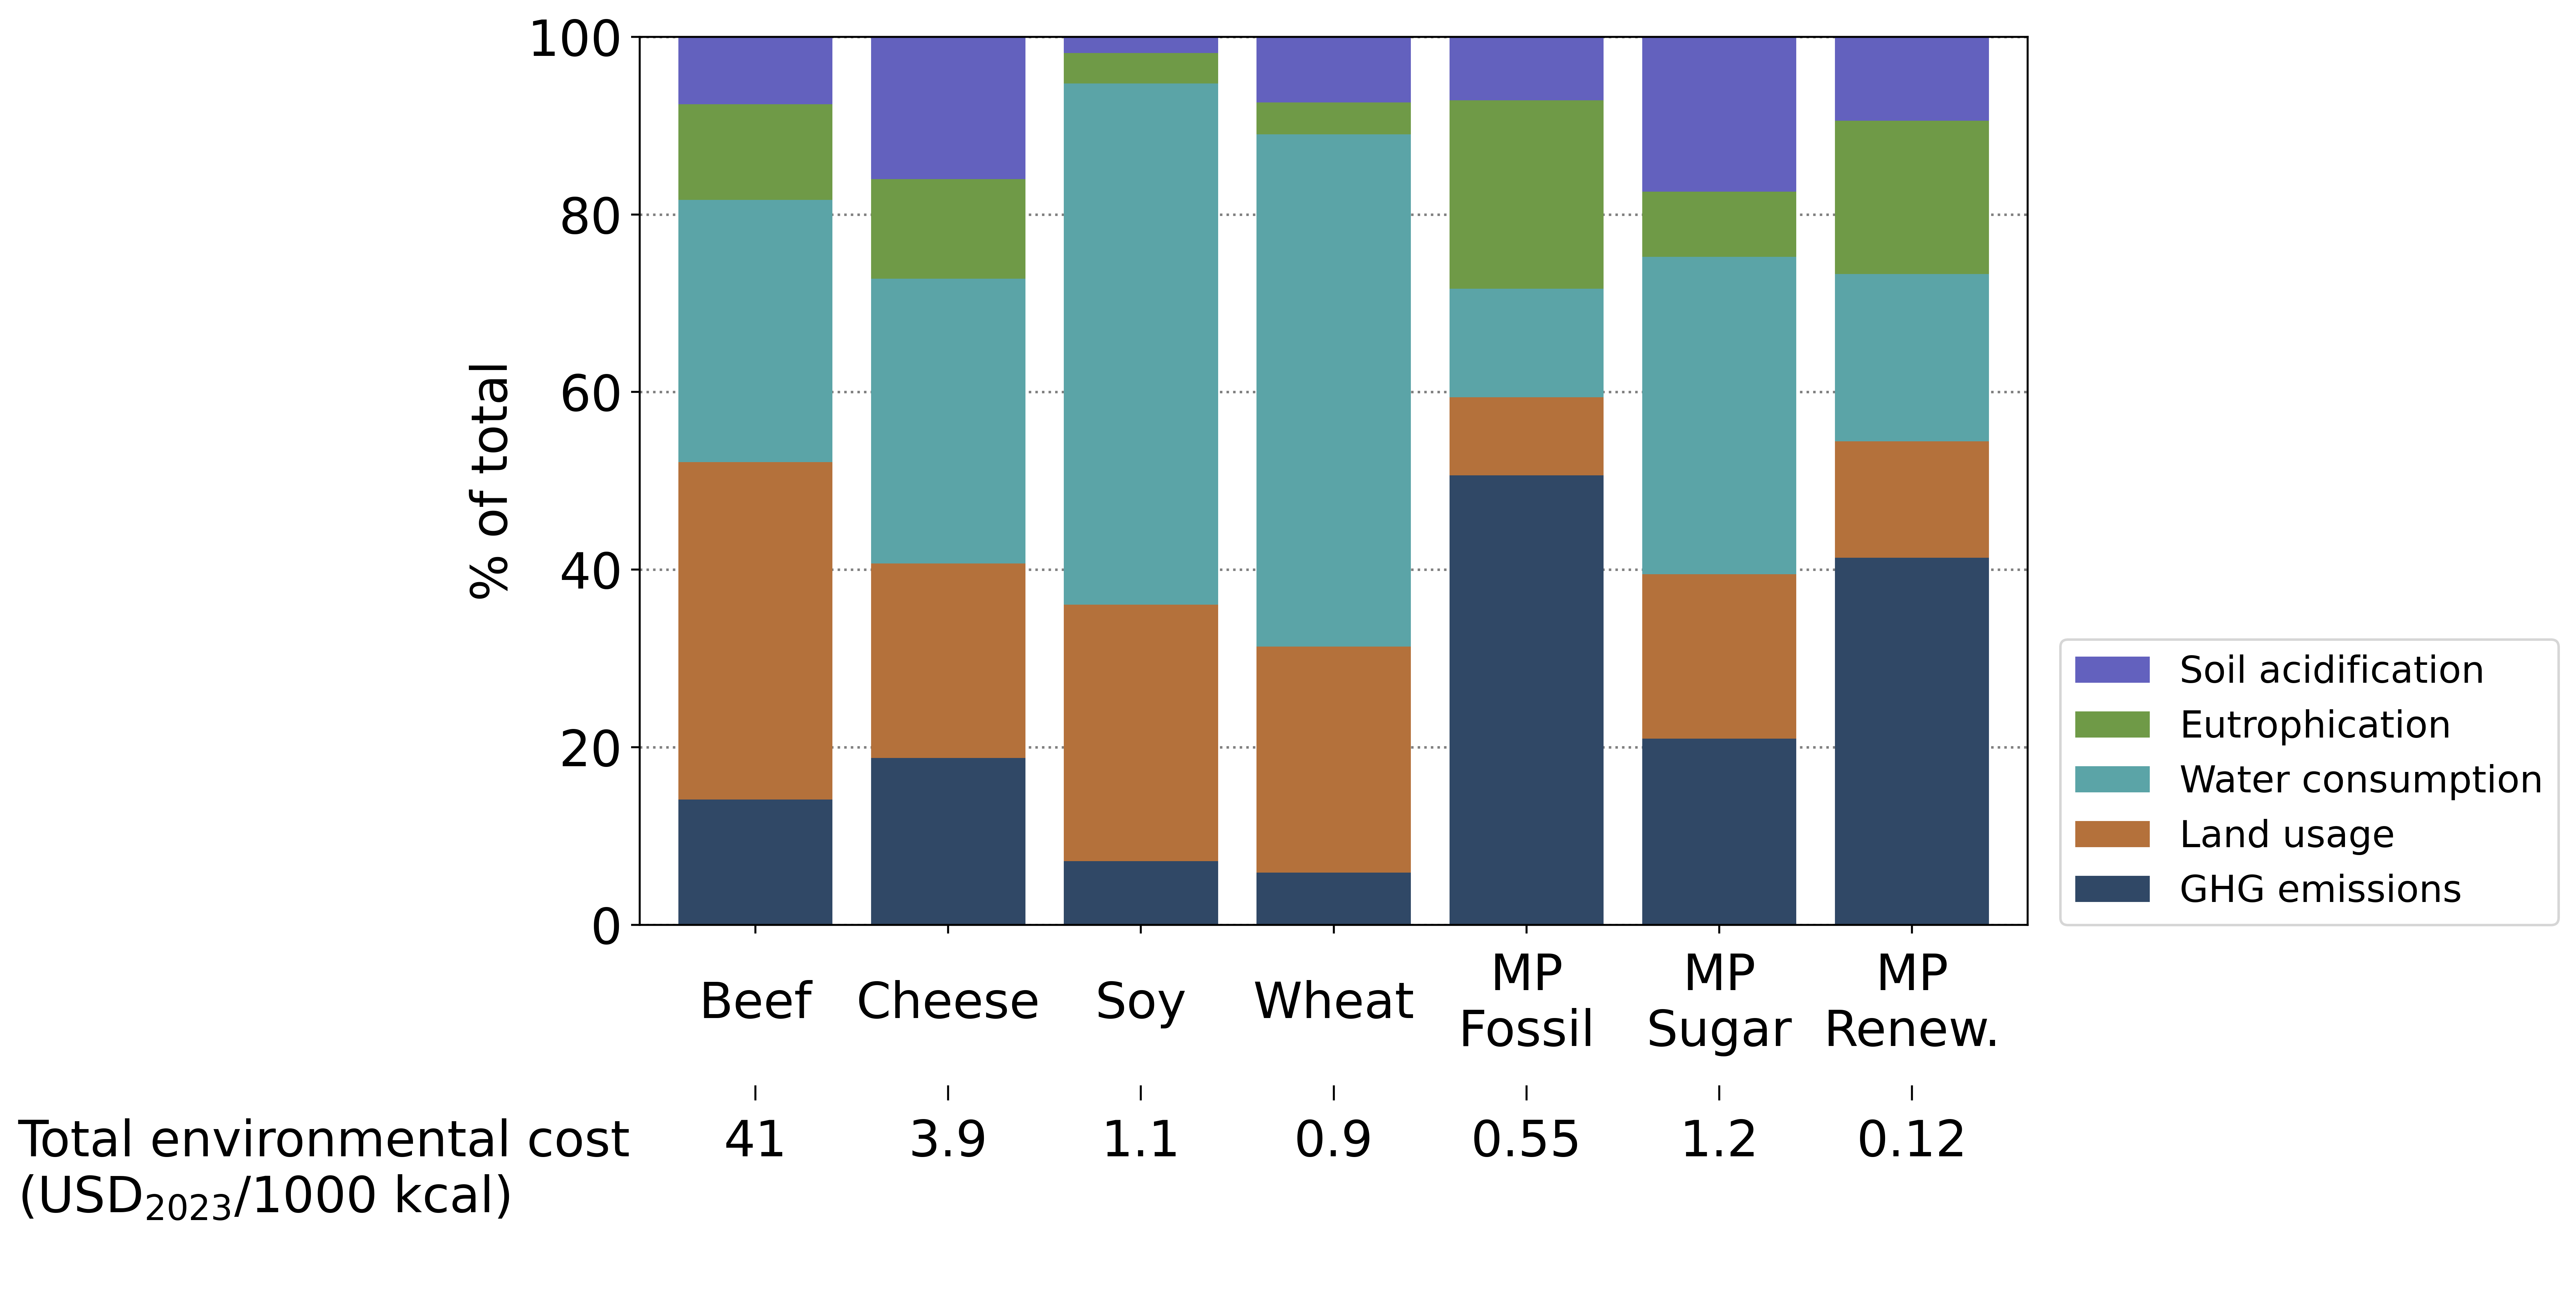

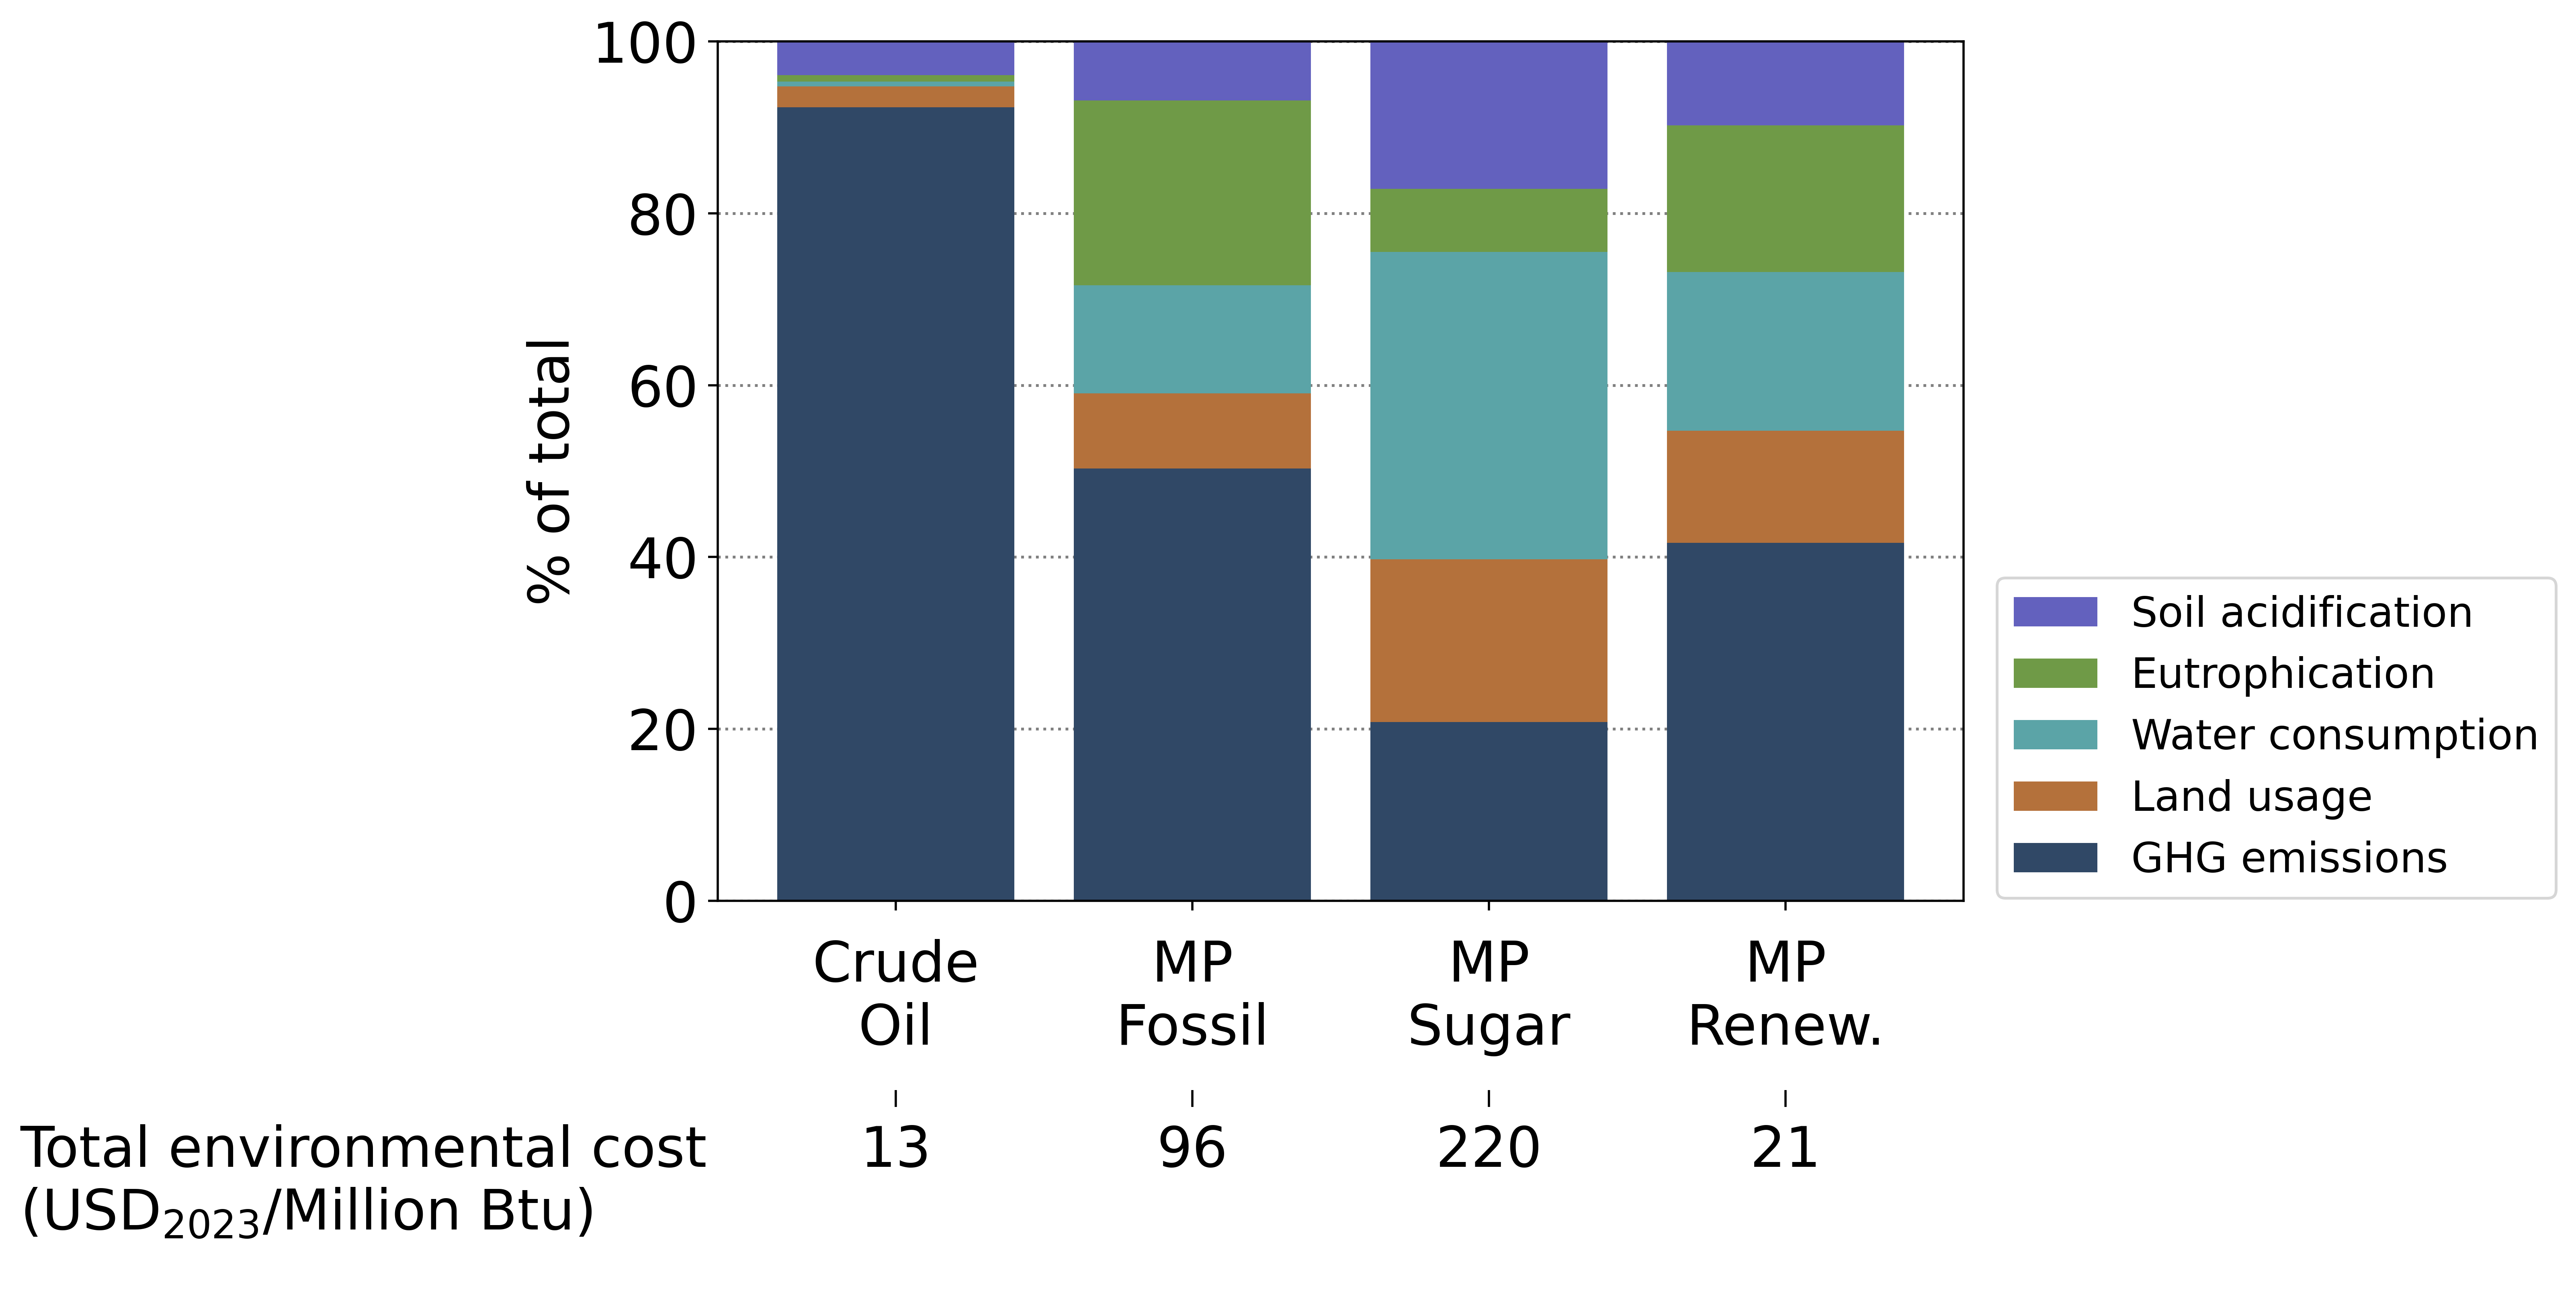

In [14]:
legend_dict = { 
    'ghg_kg_co2eq': '#304866',
    'land_m2': '#b4713b',
    'water_cons_l': '#5ba4a7',  
    'eutr_kg_phoseq': '#6f9a47',
    'acid_kg_so2eq': '#6361be',
}

# invert order so legend handles correspond to order of bars in stacked bar
handles = [
    plt.Rectangle(
        (0,0),1,1, color=legend_dict[label], ec='k', lw=0
    ) for label in list(legend_dict.keys())[::-1]
]

#rename legend_names for the actual labels shown
legend_names = [
    'GHG emissions', 
    'Land usage', 
    'Water consumption',
    'Eutrophication', 
    'Soil acidification'
][::-1]


#get same order as in other plots
ordered_products = (
    median_externalities_kg.sort_values('total_cost_w_env', ascending=False)
)
ordered_fuels = ordered_products.loc[ordered_products.index.isin(fuels)].copy()
ordered_foods = ordered_products.loc[ordered_products.index.isin(foods)].copy()
ordered_mp_fuels = (
    ordered_products.loc[ordered_products.index.isin(mp_fuel_products)].copy()
)
ordered_mp_foods = (
    ordered_products.loc[ordered_products.index.isin(mp_food_products)].copy()
)
for dataframe in [ordered_fuels, ordered_foods]:
    dataframe.sort_values('commodity_price', ascending=False, inplace=True)
ordered_mp_fuels.sort_values('commodity_price', ascending=True, inplace=True)
ordered_mp_foods.sort_values('commodity_price', ascending=True, inplace=True)
ordered_fuel_mp = pd.concat([ordered_fuels, ordered_mp_fuels])
ordered_food_mp = pd.concat([ordered_foods, ordered_mp_foods])



fig_food, ax_food = plt.subplots(
    nrows=2, 
    ncols=1,
    figsize=(10, 9), 
    dpi=500, 
    gridspec_kw={'height_ratios': [1,0.2]}
)

fig_fuel, ax_fuel  = plt.subplots(
    nrows=2, 
    ncols=1,
    figsize=(8, 8), 
    dpi=500, 
    gridspec_kw={'height_ratios': [1,0.2]}
) 
 

bar_width = 0.8
for data_to_plot, axis, fig, conversion, unit_label, save_name in (
    (ordered_food_mp, ax_food, fig_food, 1, '1000 kcal', 'food'),
    (ordered_fuel_mp, ax_fuel, fig_fuel, 252.2, 'Million Btu', 'fuel')
):
    x_pos_plot = 0
    for product in data_to_plot.index:
        bot_val = 0
        #add each environmental costs on top of each other to make stacked bar plot
        for cost in percents_env_costs_df[product].index:
            axis[0].bar(
                x=x_pos_plot, 
                height=percents_env_costs_df[(product, 'mean')].loc[cost], 
                width=bar_width, 
                color=legend_dict[cost], 
                bottom=bot_val,
            )
            bot_val += percents_env_costs_df[(product, 'mean')].loc[cost]
            
        
        #total environmental cost: median total cost minus median commodity price
        #give energy environmental cost as cost per btu
        axis[1].annotate(
            text=round_to_n(
                (
                    median_externalities_kcal['total_cost_w_env'].loc[product]
                    -median_externalities_kcal['commodity_price'].loc[product]
                )*conversion, 2
            ), 
            xy=(x_pos_plot, 0.9),
            xytext=(x_pos_plot, 0.9),
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=20,             
        )
        x_pos_plot += 1

    x_labels = list(data_to_plot.index)
    x_labels = ['Soy' if x == 'Soybeans' else x for x in x_labels]
    x_labels = [label.replace('Raw', '') for label in x_labels]
    x_labels = [label.replace('Food', '') for label in x_labels]
    x_labels = [label.replace('Renewable', 'Renew.') for label in x_labels]
    x_labels = ["\n".join(wrap(r, 7, break_long_words=False)) for r in x_labels]
    idx = np.arange(len(data_to_plot))
    
    if unit_label == 'Million Btu': 
        y_pos_xlabels = -0.09
    else: 
        y_pos_xlabels = -0.07

    axis[0].set_xticks(idx, x_labels, fontsize=20, **dict(y=y_pos_xlabels, ha='center', va='center'))
    axis[1].set_xlim(-(bar_width/2+0.2), len(data_to_plot)-1+(bar_width/2+0.2))
    axis[0].set_xlim(-(bar_width/2+0.2), len(data_to_plot)-1+(bar_width/2+0.2))
    axis[0].tick_params(axis='both', which='major', labelsize=20)
    axis[1].set_yticks([])

    axis[1].set_ylim(0,1)
    axis[0].set_ylim(0,100)
    

    axis[0].legend(
        handles, 
        legend_names, 
        fontsize=15, 
        bbox_to_anchor=(1.01, -0.021), 
        loc="lower left",
    )

    
    axis[1].set_ylabel(
        'Total environmental cost\n(USD$_{2023}$'+f'/{unit_label})', 
        fontsize=20, 
        rotation=0, 
        labelpad=250, 
        **dict(y=0.9, ha='left', va='top')
    )
    
    axis[0].set_ylabel('% of total', fontsize=20)    
    
    axis[1].spines['top'].set_visible(False)
    axis[1].spines['bottom'].set_visible(False)
    axis[1].spines['left'].set_visible(False)
    axis[1].spines['right'].set_visible(False)

    axis[1].set_xticks(np.arange(len(data_to_plot)), [])
    axis[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)
    axis[1].xaxis.set_tick_params(length=6)
    
    
    axis[0].yaxis.grid(True)
    axis[0].set_axisbelow(True)
    axis[0].yaxis.grid(
        color='grey', 
        linestyle='dotted', 
        lw=1, 
        alpha=1,
        zorder=-10
    )

    if unit_label == 'Million Btu': 
        hspace = 0.4
    else: 
        hspace = 0.33
        
    fig.subplots_adjust(hspace=hspace)
    
    #fig_food.savefig(f'{save_name}_env_cost_breakdown.svg', bbox_inches='tight')
    #fig_fuel.savefig(f'{save_name}_env_cost_breakdown.svg', bbox_inches='tight')
    